In [59]:
import matplotlib.pyplot as plt
import numpy as np
import os
import read_mist_models
from os import listdir
from os.path import isfile, join
import glob
from scipy.interpolate import *
import matplotlib.cm as cm
import math
import scipy.optimize
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib
from joblib import dump,load
import pandas as pd
CMAP = plt.cm.coolwarm

# Data-Handling Functions

In [7]:
def get_mist_data(dir_,verbose=True):
    dir_list = glob.glob(dir_+"\*.eep", recursive=True)
    age, mass, log_L,phase = [],[],[],[]
    for file in dir_list:
        eep = read_mist_models.EEP(file,verbose=verbose)
        age.append(eep.eeps['star_age'])
        mass.append(eep.eeps['star_mass'])
        log_L.append(eep.eeps['log_L'])
        phase.append(eep.eeps["phase"])
    return age, mass, log_L,phase

def flatten(arr):
    new_arr = []
    for m in arr:
        new_arr.extend(list(m))
    return new_arr


def monotonic_indices(arr):
    mon_arr = [[]]
    for x in range(len(arr)-1):
        if(arr[x+1] > arr[x]):
            mon_arr[-1].append(x)
        else: mon_arr.append([x])
    max_ind = 0
    max_size = 0
    for i in range(len(mon_arr)):
        if(np.size(mon_arr[i]) > max_size):
            max_size = np.size(mon_arr[i])
            max_ind = i
    return mon_arr[max_ind]


def clean_data(age_full, mass_full, log_L_full,phase_full):
    
    phase_full
    mass_clean, log_L_clean,age_clean=[],[],[]
    for m_list, l_list, a_list,phase in zip(mass_full, log_L_full, age_full,phase_full):
        phase=np.array(phase)
        clean_indices = np.where((np.array(phase)<0.1) & (np.array(phase) > -0.1))
        #clean_indices = monotonic_indices(l_list)

        mass_clean.append(np.array(m_list)[clean_indices]), log_L_clean.append(np.array(l_list)[clean_indices]), age_clean.append(np.array(a_list)[clean_indices])
    return age_clean, mass_clean, log_L_clean

def get_MIST_tracks_and_feh(feh_range):
    all_tracks = np.sort(glob.glob("MIST_high_res/*"))
    all_tracks = np.concatenate((all_tracks[-3:][::-1],all_tracks[0:-3]))
    filtered_tracks = []
    feh = []
    for track in all_tracks:
        s = (track.split("feh_")[-1]).split("_")[0]
        sign = s[0]
        if(sign == "p"): sign = 1
        else: sign = -1
        feh_val = float(s[1:])*sign
        if(is_in(feh_val, feh_range)):
            feh.append(feh_val)
            filtered_tracks.append(track)
    return filtered_tracks, feh



def get_all_MIST_data(all_tracks, clean=True, verbose=True):
    all_ages, all_mass, all_L, all_ages_full, all_mass_full, all_L_full,all_phases_full = [],[],[],[],[],[],[]
    for i,tracks in enumerate(all_tracks):
        age_full, mass_full, log_L_full,phase_full = get_mist_data(tracks,verbose=verbose)
        all_mass_full.append(mass_full)
        all_ages_full.append(age_full)
        all_L_full.append(log_L_full)
        all_phases_full.append(phase_full)
        if(clean):
            age, mass, log_L = clean_data(age_full, mass_full, log_L_full,phase_full)
            all_ages.append(age), all_mass.append(mass), all_L.append(log_L)
        else:
            all_ages.append(age_full), all_mass.append(mass_full), all_L.append(log_L_full)

    return all_ages, all_mass, all_L, all_ages_full, all_mass_full, all_L_full,all_phases_full



# Analysis Functions

In [8]:


def is_in(x_eval, x_list):
    return ((np.any(np.array(x_list) <= x_eval)) and (np.any(np.array(x_list) >= x_eval)))

def interp_1d(x,y,x_eval, interp_type):
    y_out =[]
    for x_list, y_list in  zip(x, y):        
        if(is_in(x_eval, x_list)):
            y_out.append(interp1d(x_list,y_list, kind=interp_type)(x_eval))
    return np.array(y_out)



def get_l_stables(age, mass, log_L, a_start, m_eval, lmsq):
    
    m_interp = interp_1d(age, mass, a_start, "linear")
    l_interp = interp_1d(age, log_L, a_start, "linear")
    m_eval_temp = m_eval[np.where(m_eval <= np.max(m_interp))]
    try:
        l_stables = interp1d(m_interp,l_interp, kind="linear")(m_eval_temp)
        if(lmsq): 
#             print("YEP")
#             print(np.power(10,l_stables)*np.power(m_eval_temp,2))
#             print(l_stables, m_eval_temp)
            return np.power(10,l_stables)*np.power(m_eval_temp,2)
        else: return l_stables
    except Exception as e:
        print(m_interp, l_interp, m_eval)
        print(e)
        return []
        

def exp(x, a,b,c):
    return a * np.exp(-b * x) + c

def pow_law(x, a,b,c,base):
    return a * np.power(base,-b * x) + c

def exp_der(x, a,b,c):
    return -b*a * np.exp(-b * x)



def chi_sq(data,fit):
    return np.sum(np.power(fit-data,2)/fit)

def residual(data,fit):
    return np.sum(np.power(fit-data,2))


def get_fits(age, mass, log_L,l_stables,a_start,lmsq, SIGMA=False,poly=False):
    a,m,fit,indices = [],[],[],[]
    poly_fits = []
    for i,l_stable in enumerate(l_stables): 
    
        if(lmsq):
            interp_over = []
            for x in range(len(mass)): interp_over.append(np.array(np.power(10,log_L[x])*np.power(mass[x],2)))
            m_interp = interp_1d(interp_over,mass, l_stable, "linear")[::-1]
            a_interp = interp_1d(interp_over,age, l_stable, "linear")[::-1]
        else:
            m_interp = interp_1d(log_L,mass, l_stable, "linear")[::-1]
            a_interp = interp_1d(log_L,age, l_stable, "linear")[::-1]

        inds = np.where(a_interp > a_start)
        m_interp = m_interp[inds]
        a_interp = a_interp[inds]
        if(len(m_interp)<2):  continue
        indices.append(i)

        m.append(m_interp)
        a.append(a_interp)
        
        if(poly):
            fit.append(np.polyfit(a_interp,m_interp,3))
        else:

            try:
                p0 = (m_interp[0]-m_interp[-1],2/(np.abs(a_interp[0] - a_interp[-1])),m_interp[-1])

                if(SIGMA):
                    if(np.max(a_interp) < 80e9):
                        one_over_dif =np.abs(1/np.power((a_interp[1:] -a_interp[:-1]),1))
                        sigma=np.insert(one_over_dif,0,np.min(one_over_dif))   #np.array([1/((n+1)*(n+1)) for n in range(len(a_interp))])
                        sigma=np.sqrt(sigma)
                        params, cv = scipy.optimize.curve_fit(exp, a_interp, m_interp, p0, sigma=sigma)
                    else:
                        params, cv = scipy.optimize.curve_fit(exp, a_interp, m_interp, p0)
                else:
                    params, cv = scipy.optimize.curve_fit(exp, a_interp, m_interp, p0)

                fit.append(params)

            except Exception as e:
                print(e)
                print("Failed to fit exponential. age, mass:", list(a_interp), list(m_interp))
                fit.append((0,1,0))
    return a,m,fit,indices


def get_m_vs_a(all_ages, all_mass, all_L,feh, m_eval,a_start, lmsq=True, poly=False):
    all_l_stables, all_a, all_m, all_fits,all_indices = [],[],[],[],[]
    for age,mass,log_L,i, met in zip(all_ages, all_mass, all_L, range(len(all_ages)), feh):

        l_stables = get_l_stables(age, mass, log_L, a_start, m_eval, lmsq)
        if(len(l_stables) > 0):
            a,m,fit, indices = get_fits(age, mass, log_L,l_stables,a_start,lmsq,SIGMA=True,poly=poly)
            all_l_stables.append(l_stables)
            all_a.append(a)
            all_m.append(m)
            all_indices.append(indices)
            all_fits.append(fit)

    return all_l_stables, all_a, all_m, all_fits,all_indices

# Generating Mass vs age for several metallicities

In [105]:
all_tracks, feh = get_MIST_tracks_and_feh(feh_range=[-4.1,0.6])
all_ages, all_mass, all_L, all_ages_full, all_mass_full, all_L_full,all_phases_full = get_all_MIST_data(all_tracks, clean=True,verbose=True)

Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0003900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0004000M.track.eep
Reading in: MIST_high

Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0012400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0012500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0012600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0012700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0012800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0012900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0013000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0013100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0013200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0013300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS\0013400M.track.eep
Reading in: MIST_high

Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0008700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0008800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0008900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0009000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0009100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0009200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0009300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0009400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0009500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0009600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_EEPS\0009700M.track.eep
Reading in: MIST_high

Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0005400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0005500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0005600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0005700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0005800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0005900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0006000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0006100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0006200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0006300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0006400M.track.eep
Reading in: MIST_high

Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0014800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0014900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.4_EEPS\0015800M.track.eep
Reading in: MIST_high

Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0011900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0012000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.4_EEPS\0012100M.track.eep
Reading in: MIST_high

Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0007400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0007500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0007600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0007700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0007800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0007900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0008000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0008100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0008200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0008300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.4_EEPS\0008400M.track.eep
Reading in: MIST_high

Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0003900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0004900M.track.eep
Reading in: MIST_high

Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0013200M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0013300M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0013400M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0013500M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0013600M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0013700M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0013800M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0013900M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0014000M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0014100M.track.eep
Reading in: MIST_high_res\MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.4_EEPS\0014200M.track.eep
Reading in: MIST_high

In [10]:
# ages,masses,lums = all_ages[0],all_mass[0],all_L[0]
# for x in range(len(ages)):
#     if(masses[x][0]>1.4 or masses[x][0]<0.4):continue
#     plt.figure()
#     plt.yscale("log")
#     plt.xlim(0,60e9)
#     plt.scatter(ages[x], np.power(10,lums[x])*np.power(masses[x],2))
    
#     plt.title("mass = "+str(masses[x][0])+"lmas = "+str(lums[x][-1]))
#     plt.show()

In [106]:
a_sol = 4.603e9
m_sol = 1.98847e30
m_ceres = 9.1e20
a_start = 2e9 #the age when starlifting starts
m_eval = np.arange(0.4,1.4,0.02)
POLY=True
all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_L,feh,m_eval,a_start,poly=POLY)

<ipython-input-8-7345d05a184f>:106: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, log_L,l_stables,a_start,lmsq,SIGMA=True,poly=poly)
<ipython-input-8-7345d05a184f>:106: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, log_L,l_stables,a_start,lmsq,SIGMA=True,poly=poly)


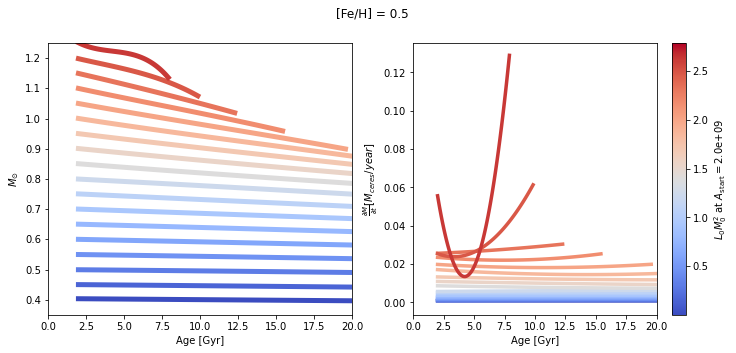

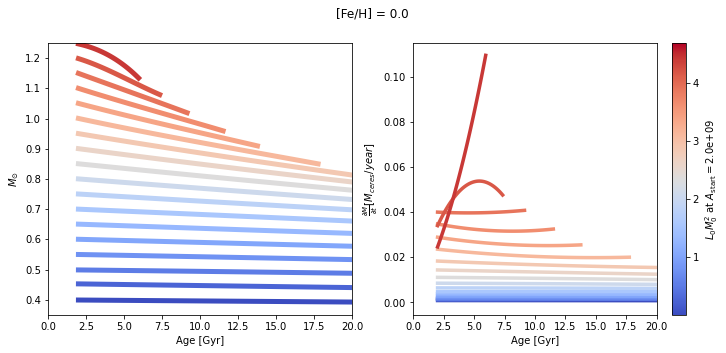

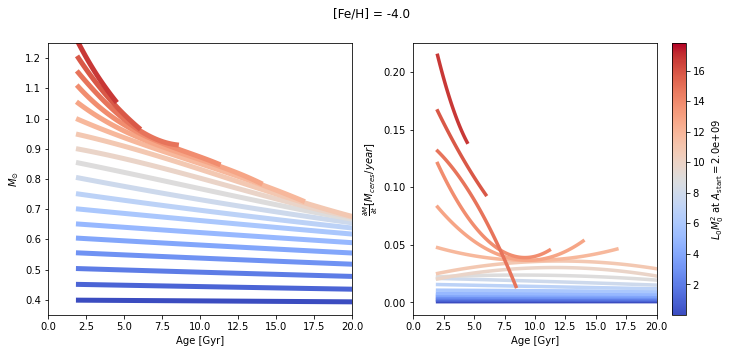

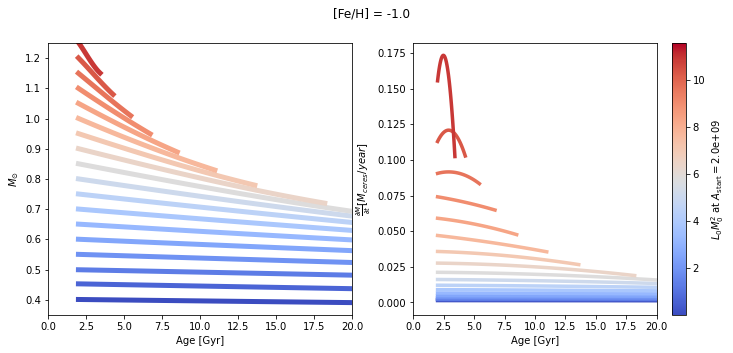

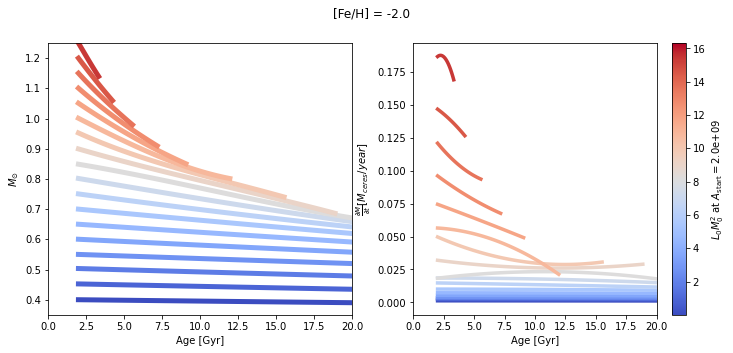

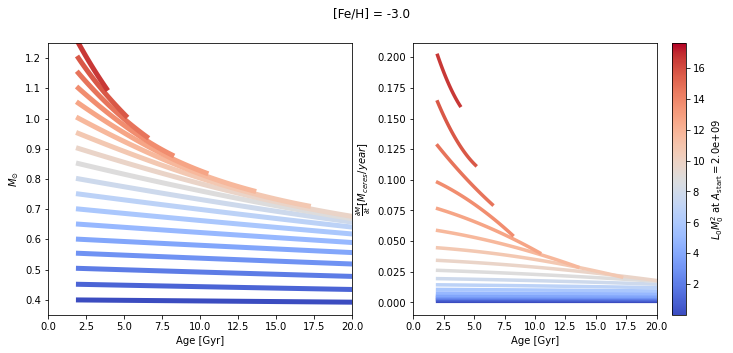

In [390]:
for i in range(len(all_indices)) :
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    
    for x in range(len(all_m[i])):
        pts = np.linspace(a_start, min(60e9,max(all_a[i][x])),120)


    for num,x in enumerate(all_indices[i]):
        pts = np.linspace(a_start, min(20e9,max(all_a[i][num])),120)
        if(POLY):
            poly = np.polyfit(all_a[i][num],all_m[i][num],3)
            axs[0].plot(pts/1e9, np.poly1d(poly)(pts), color=CMAP(x/len(all_l_stables[i])), lw=5)
            axs[1].plot(pts/1e9, -np.polyder(np.poly1d(poly))(pts)*m_sol/m_ceres, color=CMAP(x/len(all_l_stables[i])), lw=3.5)

        else:
            a,b,c = all_exp_fits[i][num]
            axs[0].plot(pts/1e9, exp(pts,a,b,c), color=CMAP(x/len(all_l_stables[i])), lw=4)
            axs[1].plot(pts/1e9, -exp_der(pts,a,b,c)*m_sol/m_ceres, color=CMAP(x/len(all_l_stables[i])), lw=4)
        
    c = axs[1].scatter(np.zeros(len(all_l_stables[i])), np.zeros(len(all_l_stables[i])), cmap=CMAP, c=all_l_stables[i], s=0)
    axs[0].set_xlim(0,20)
    axs[0].set_ylim(m_eval[0]-0.05, m_eval[-1])
    axs[0].set_xlabel("Age [Gyr]")
    axs[0].set_ylabel(r"$M_{\odot}$")

    axs[1].set_xlim(0,20)
    axs[1].set_xlabel("Age [Gyr]")
    axs[1].set_ylabel(r"$\frac{\partial M}{\partial t} [M_{ceres}/year]$")
    #fig.colorbar(c, label=r"log($\frac{L_{stable}}{L_{\odot}}$) at $A_{\rm start}=$"+str(f"{a_start:.1e}"))    
    fig.colorbar(c, label=r"$L_0 M_0^2$ at $A_{\rm start}=$"+str(f"{a_start:.1e}"))    

    plt.suptitle("[Fe/H] = "+str(feh[i]))
    if(feh[i] < 0): feh_st = "m"+str(np.abs(feh[i]))
    else: feh_st = "p"+str(np.abs(feh[i]))
    plt.savefig("figures/fit_figs_w_lmsq/feh_"+feh_st+".pdf")
    

# Comparing lifetimes between SL and regular stars

In [442]:
def get_lifetime_ratios(all_ages, all_mass, all_a, all_m,feh):
    X = []
    for i in range(len(feh)):
        starting_mass = []
        for j in range(len(all_mass[i])): 
            starting_mass.append(all_mass[i][j][0])
        stating_mass = np.array(starting_mass)
        
        for j in range(len(all_m[i])):
            init_mass = all_m[i][j][0]
            new_age = all_a[i][j][-1]
            track_ind = np.argmin(np.abs(starting_mass-init_mass))
            expected_age = all_ages[i][track_ind][-1]
            X.append((init_mass, new_age, expected_age, new_age/expected_age, feh[i]))
    return X

X = get_lifetime_ratios(all_ages, all_mass, all_a, all_m,feh)

In [443]:
X2 = np.array(X).T
init_mass = X2[0]
feh_list = X2[-1]
ratio = X2[-2]

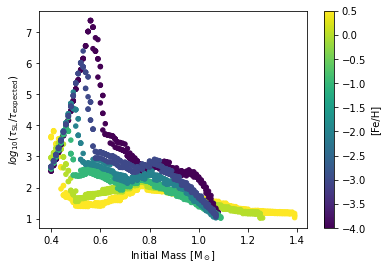

In [444]:
plt.scatter(init_mass, ratio, c=feh_list, s=20,cmap=cm.viridis)
plt.colorbar(label="[Fe/H]")
plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
plt.ylabel(r"$log_{10}(\tau_{\rm SL} / \tau_{\rm expected})$")
plt.savefig("figures/lifetime_ratios_astart_4gyr.pdf")

# Plotting all of the MIST main-sequence data which we'll be interpolating over

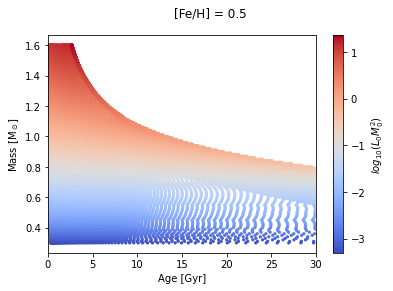

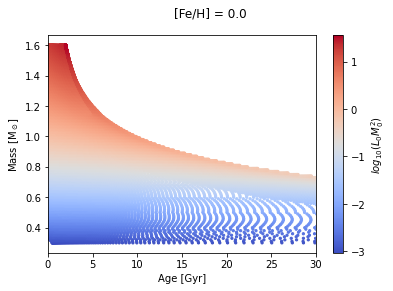

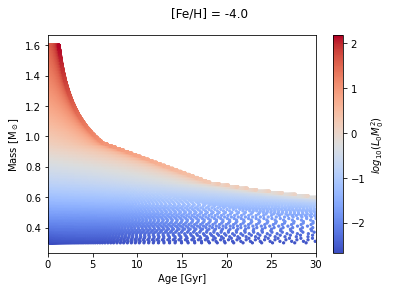

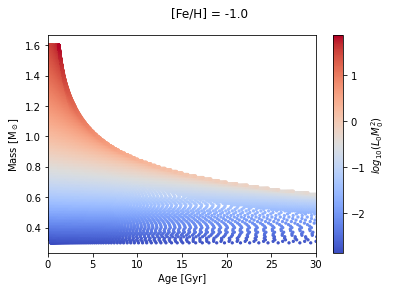

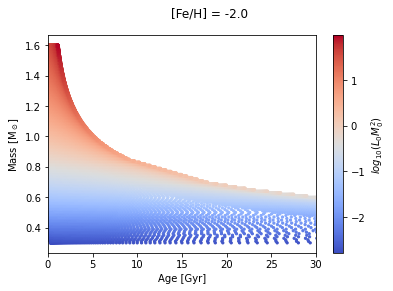

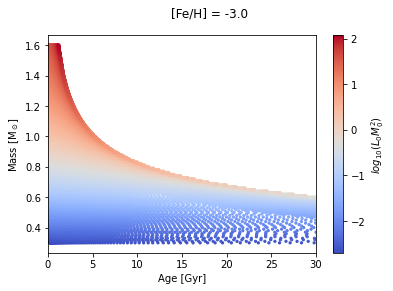

In [72]:
for i in range(len(feh)) :
    fig = plt.figure()
    vmax, vmin = np.log10(np.max(np.power(10,all_L[i])*np.power(all_mass[i],2))),np.log10(np.min(np.power(10,all_L[i])*np.power(all_mass[i],2)))
    for mass,age,log_l in zip(all_mass[i], all_ages[i], all_L[i]):
        plt.scatter(age/1e9,mass, cmap=CMAP, c=np.log10(np.power(10,log_l)*np.power(mass,2)),s=5, vmin=vmin, vmax=vmax)
        
    plt.xlim(0,30)
    plt.xlabel("Age [Gyr]")
    plt.ylabel(r"Mass [${\rm M}_\odot$]")
    plt.colorbar(label=r"$log_{10}(L_0 M_0^2)$")
    plt.suptitle("[Fe/H] = "+str(feh[i]))
    if(feh[i] < 0): feh_st = "m"+str(np.abs(feh[i]))
    else: feh_st = "p"+str(np.abs(feh[i]))
    plt.savefig("figures/MIST_dense/feh_"+feh_st+".pdf")

# Solar SL vs no SL for luminosity and mass

In [44]:
initial_masses_sl, initial_masses_norm = [],[]
for x in range(len(all_m[1])): initial_masses_sl.append(all_m[1][x][0])
for x in range(len(all_mass[1])): initial_masses_norm.append(all_mass[1][x][0])
ind_sl = np.argmin(np.abs(np.array(initial_masses_sl)-1))
ind_norm = np.argmin(np.abs(np.array(initial_masses_norm)-1))
solar_mass_sl, solar_age_sl, solar_lum_sl= all_m[1][ind_sl], all_a[1][ind_sl], np.linspace(all_l_stables[1][ind_sl],all_l_stables[1][ind_sl],len(all_m[1][ind_sl]))
solar_mass_norm, solar_age_norm, solar_lum_norm= all_mass[1][ind_norm], all_ages[1][ind_norm], np.power(10,all_L[1][ind_norm])*np.power(all_mass[1][ind_norm],2)

overlap_inds = np.where(solar_age_norm < solar_age_sl[0])

solar_mass_sl =np.append(solar_mass_norm[overlap_inds], solar_mass_sl)
solar_age_sl =np.append(solar_age_norm[overlap_inds], solar_age_sl)
solar_lum_sl =np.append(solar_lum_norm[overlap_inds], solar_lum_sl)


In [ ]:
np.power(10,log_l)

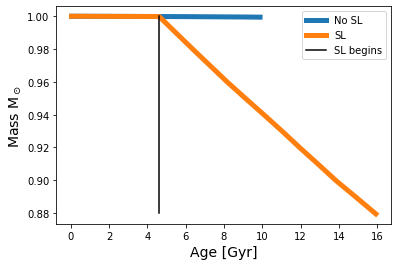

In [57]:
plt.plot(solar_age_norm/1e9,solar_mass_norm, label = "No SL",lw=5,c="tab:blue")
plt.plot(solar_age_sl/1e9,solar_mass_sl, label = "SL", lw=5,c="tab:orange")
plt.plot(np.linspace(a_start/1e9,a_start/1e9,20), np.linspace(.88,1, 20), label="SL begins", c="black")
plt.legend()
plt.xlabel("Age [Gyr]", size=14)
plt.ylabel(r"Mass ${\rm M}_\odot$", size=14)
plt.savefig("figures/solar_m_vs_a.png")

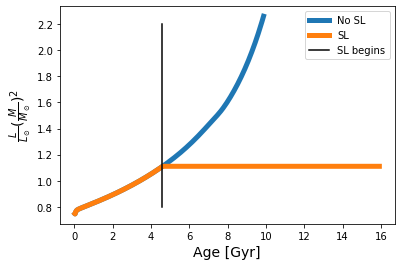

In [58]:
plt.plot(solar_age_norm/1e9,solar_lum_norm, label = "No SL",lw=5,c="tab:blue")
plt.plot(solar_age_sl/1e9,solar_lum_sl, label = "SL", lw=5,c="tab:orange")
plt.plot(np.linspace(a_start/1e9,a_start/1e9,20), np.linspace(0.8,2.2, 20), label="SL begins", c="black")

plt.legend()
plt.xlabel("Age [Gyr]", size=14)
plt.ylabel(r"$\frac{L}{L_\odot}(\frac{M}{M_\odot})^2$", size=14)
plt.savefig("figures/solar_l_vs_a.png")

# ML stuff, using ML rather than curve fitting.

In [142]:
def norm(X,lo,up):
    X=np.array(X)
    return (X-lo)/(up-lo)

def norm_inv(X,lo,up):
    X=np.array(X)
    return X*(up-lo) + lo

class ml_bounds:
    mass_min= 0
    mass_max= 1.7
    age_min= a_start
    age_max= 65e9
    dmdt_min= 0
    dmdt_max= 0.3
    l_min=-5
    l_max=10
    feh_min= 1.5
    feh_max= -5


def prep_ML_data1(all_indices, all_exp_fits, all_l_stables,feh, a_start):
    ml_mass, ml_l, ml_feh, ml_dmdt,ml_age =[],[],[],[],[]
    #pts = np.linspace(a_start, 60e9,1500)
    for i in range(len(all_indices)) :    
        for num,x in enumerate(all_indices[i]):
            a,b,c = all_exp_fits[i][num]
            if(num > 0): a2,b2,c2= all_exp_fits[i][num-1]
            pts = np.linspace(a_start, min(60e9, np.max(all_a[i][num])*.95),1500)
            for age_ in pts:
                m1=exp(age_,a,b,c)
                if(num>0):
                    m2=exp(age_,a2,b2,c2)
#                     m3=-exp_der(age_,a,b,c)
#                     m4=-exp_der(age_,a2,b2,c2)
#                     if(m1<m2 or m3<m4):
#                         continue
                    if(m1<m2):
                        continue                  
                ml_age.append(age_)
                ml_mass.append(m1)
                ml_l.append(all_l_stables[i][x])
                ml_feh.append(feh[i])
                ml_dmdt.append(-exp_der(age_,a,b,c)*m_sol/m_ceres) 
    
    b = ml_bounds()
    ml_age =  norm(ml_age, b.age_min,b.age_max)
    ml_mass = norm(ml_mass,b.mass_min,b.mass_max)
    ml_l = norm(ml_l,b.l_min,b.l_max)
    ml_feh = norm(ml_feh, b.feh_min,b.feh_max)
    ml_dmdt = norm(ml_dmdt,b.dmdt_min,b.dmdt_max)
    all_X = [ml_age, ml_mass, ml_l, ml_feh, ml_dmdt]
    if(np.max(all_X) > 1 or np.min(all_X) <0): 
        print("Norm Error, max=",np.max(all_X), " min=", np.min(all_X))

    X,Y = [],[]
    for i in range(len(ml_mass)):
        X.append((ml_age[i], ml_l[i], ml_feh[i]))
        Y.append((ml_mass[i],ml_dmdt[i]))
    return X,Y

def prep_ML_data2(all_indices, all_exp_fits, all_l_stables,feh, a_start):
    ml_mass, ml_l, ml_feh, ml_dmdt,ml_age =[],[],[],[],[]
    for i in range(len(all_indices)) :    
        for num,x in enumerate(all_indices[i]):
            for z in range(len(all_a[i][num])):
                if(all_a[i][num][z] > 60e9): continue
                ml_age.append(all_a[i][num][z])
                ml_mass.append(all_m[i][num][z])
                ml_l.append(all_l_stables[i][x])
                ml_feh.append(feh[i])
                ml_dmdt.append(0) 

    b = ml_bounds()
    ml_age =  norm(ml_age, b.age_min,b.age_max)
    ml_mass = norm(ml_mass,b.mass_min,b.mass_max)
    ml_l = norm(ml_l,b.l_min,b.l_max)
    ml_feh = norm(ml_feh, b.feh_min,b.feh_max)
    ml_dmdt = norm(ml_dmdt,b.dmdt_min,b.dmdt_max)
    all_X = [ml_age, ml_mass, ml_l, ml_feh, ml_dmdt]
    if(np.max(all_X) > 1 or np.min(all_X) <0): 
        print("Norm Error, max=",np.max(all_X), " min=", np.min(all_X))

    X,Y = [],[]
    for i in range(len(ml_mass)):
        X.append((ml_age[i], ml_l[i], ml_feh[i]))
        Y.append((ml_mass[i],ml_dmdt[i]))
    return X,Y


def prep_ML_data3(all_ages, all_mass, all_L, feh,lmsq):
    ml_age, ml_mass,ml_l,ml_feh =[],[],[],[]
    for x in range(len(feh)):
        #feh=askldjakljd
        for y in range(len(all_ages[x])):
            for age,mass,log_L in zip(all_ages[x][y], all_mass[x][y], all_L[x][y]):
                if(age>60e9):continue
                ml_age.append(age)
                ml_mass.append(mass)
                if(lmsq): ml_l.append(np.power(10,log_L)*mass*mass)
                else: ml_l.append(log_L)
                ml_feh.append(feh[x])
    
    b = ml_bounds()
    
    ml_age =  norm(ml_age, b.age_min,b.age_max)
    ml_mass = norm(ml_mass,b.mass_min,b.mass_max)
    ml_l = norm(ml_l,b.l_min,b.l_max)
    ml_feh = norm(ml_feh, b.feh_min,b.feh_max)
    all_X = [ml_age, ml_mass, ml_l, ml_feh]
    if(np.max(ml_age) > 1 or np.min(ml_age) <0): print("Norm Error,ml_age max=",np.max(ml_age), " min=", np.min(ml_age))
    if(np.max(ml_mass) > 1 or np.min(ml_mass) <0): print("Norm Error,ml_mass max=",np.max(ml_mass), " min=", np.min(ml_mass))
    if(np.max(ml_l) > 1 or np.min(ml_l) <0): print("Norm Error,ml_l max=",np.max(ml_l), " min=", np.min(ml_l))
    if(np.max(ml_feh) > 1 or np.min(ml_feh) <0): print("Norm Error ml_feh, max=",np.max(ml_feh), " min=", np.min(ml_feh))

    X,Y = [],[]
    for i in range(len(ml_mass)):
        X.append((ml_age[i], ml_l[i], ml_feh[i]))
        Y.append((ml_mass[i]))
    return X,Y

def calc_ML(f_list,a_list,l_list):
    X_base = []
    b=ml_bounds()

    for f in norm(f_list, b.feh_min,b.feh_max):
        for lum in norm(l_list, b.l_min,b.l_max):
            for age in norm(a_list, b.age_min,b.age_max):
                X_base.append((age,lum,f))  

    out = regr.predict(X_base)
    m_predict = norm_inv(out.T[0], b.mass_min, b.mass_max)
    dmdt_predict = norm_inv(out.T[1],b.dmdt_min, b.dmdt_max)
    age_in = norm_inv(np.array(X_base).T[0], b.age_min, b.age_max)
    lum_in = norm_inv(np.array(X_base).T[1], b.l_min,b.l_max)
    feh_in = norm_inv(np.array(X_base).T[2], b.feh_min,b.feh_max)
    
    return m_predict,dmdt_predict,age_in,lum_in,feh_in



In [159]:
X,Y = prep_ML_data3(all_ages, all_mass, all_L, [0.0],True)
X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state=1)

In [175]:
print(norm_inv(y_test,b.mass_min,b.mass_max))

[0.55984421 0.68975958 1.51983142 ... 1.09947799 0.81986427 0.84999679]


In [160]:
regr = MLPRegressor(random_state=1, max_iter=700, hidden_layer_sizes=(700,),alpha = 0.000001, tol=1e-5).fit(X_train, y_train)

In [161]:
regr.score(X_test, y_test)

0.9848020833637547

In [176]:
b=ml_bounds()
a_eval = norm(np.linspace(2e9,60e9,300), b.age_min,b.age_max)
l_eval = norm(np.linspace(1,1,300), b.l_min,b.l_max)
f_eval = norm(np.linspace(0,0,300), b.feh_min,b.feh_max)
X=[]
for a,c,d in zip(a_eval,l_eval,f_eval):
    X.append((a,c,d))

In [73]:
#dump(regr, "ml_model_monotonic.joblib")
#regr = load('ml_model_monotonic.joblib') 

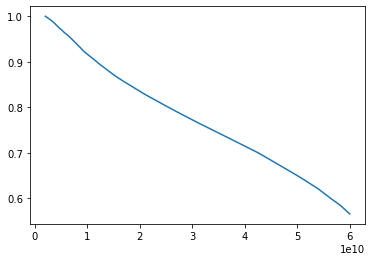

In [178]:
plt.plot(np.linspace(2e9,60e9,300),norm_inv(regr.predict(X),b.mass_min, b.mass_max))

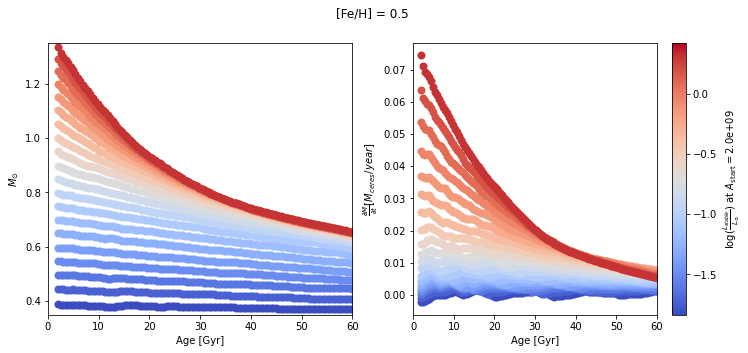

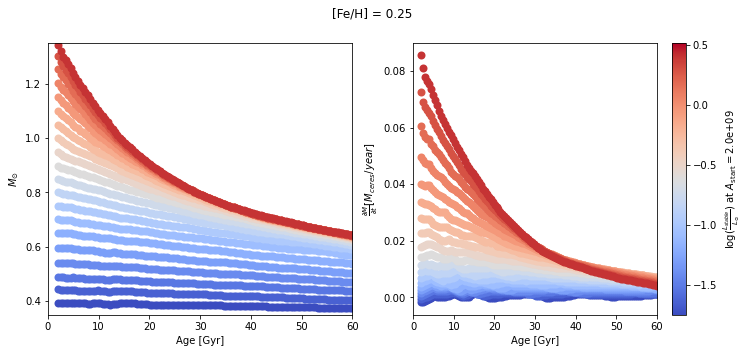

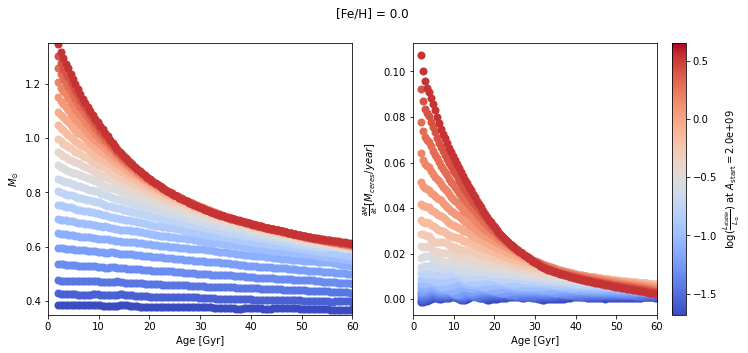

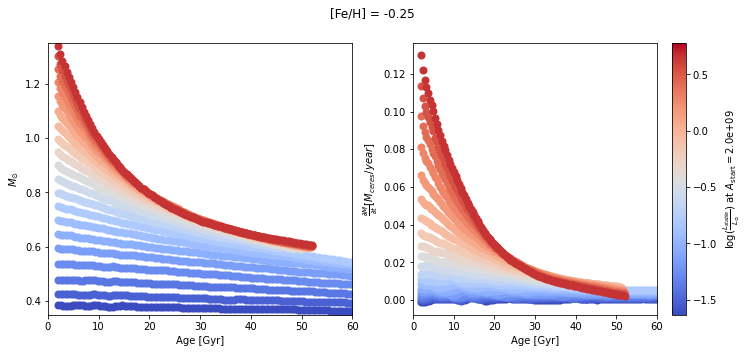

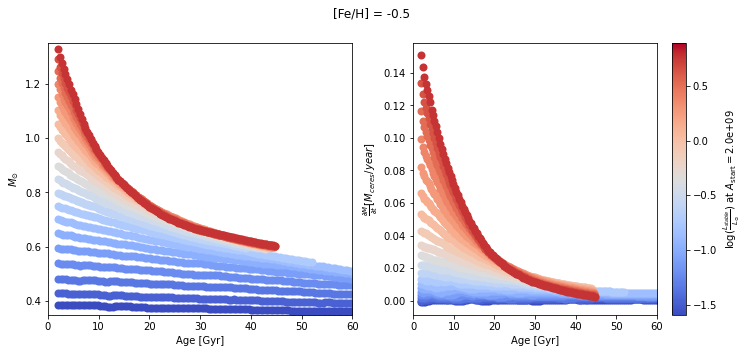

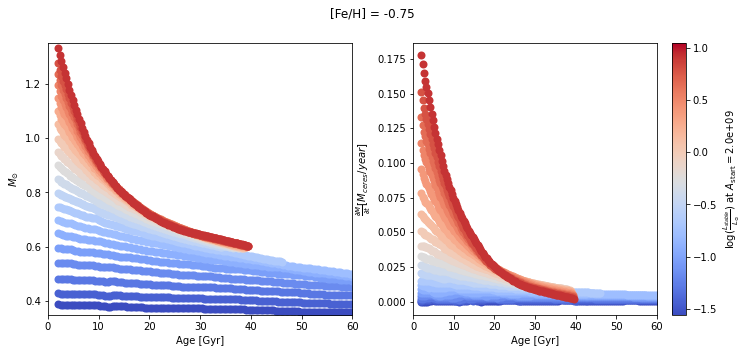

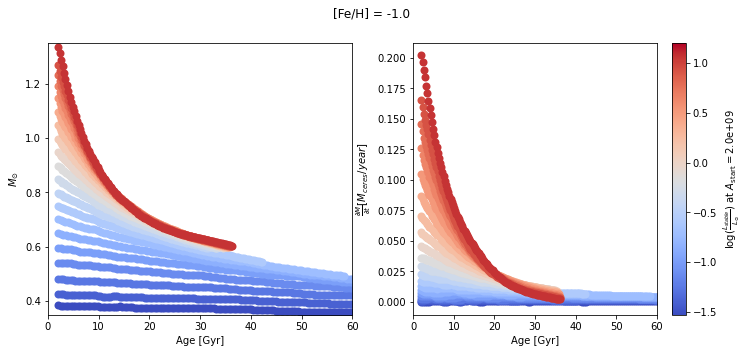

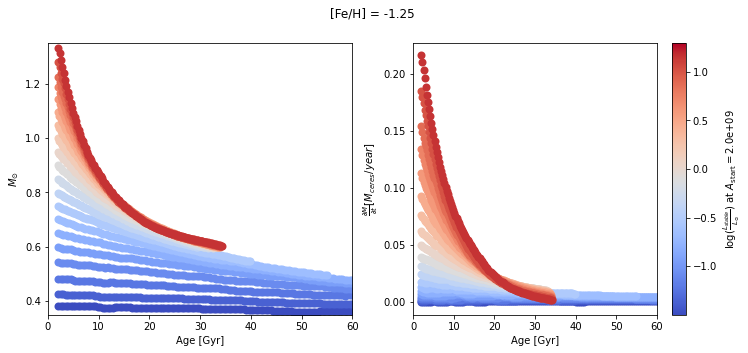

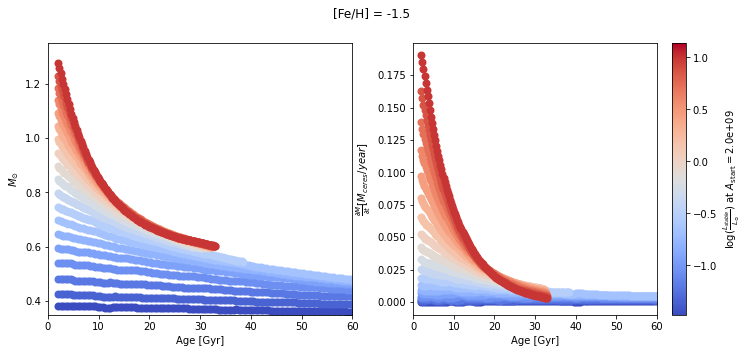

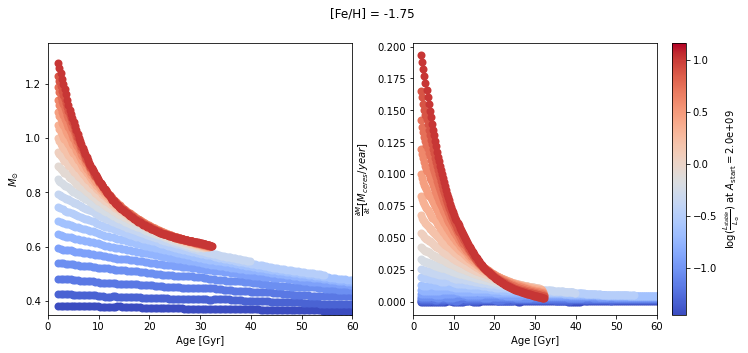

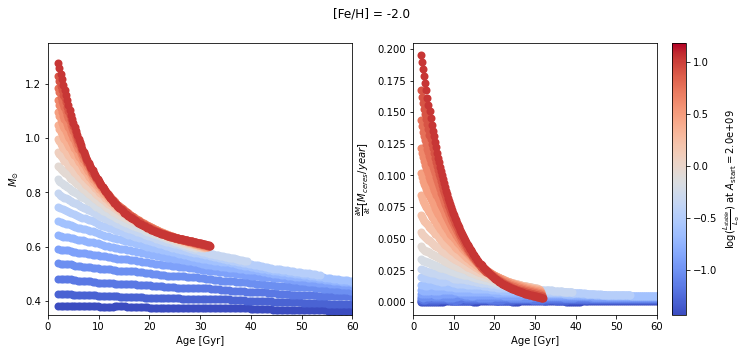

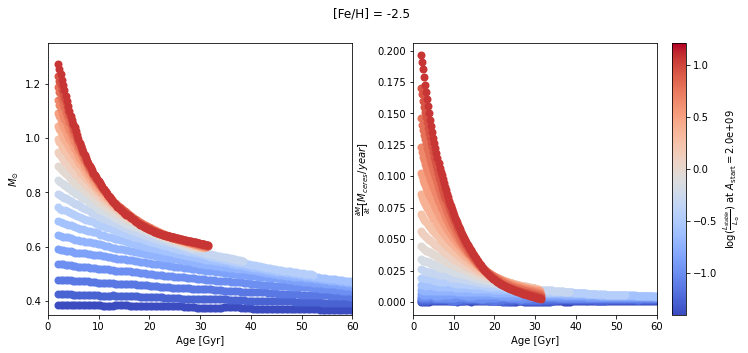

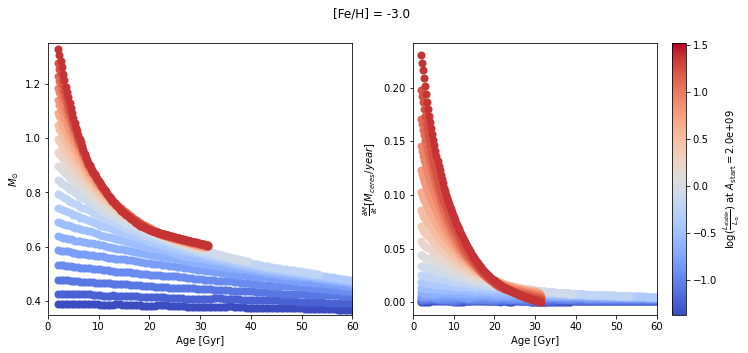

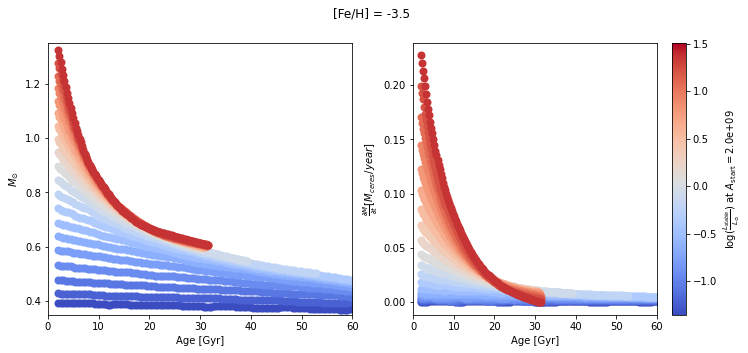

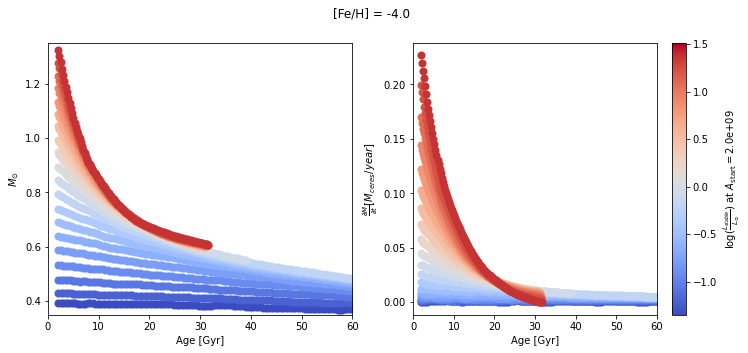

In [196]:
for i in range(len(all_indices)) :
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    
    for num,x in enumerate(all_indices[i]):
        pts = np.linspace(a_start, min(60e9,max(all_a[i][num])),120)
        
        m_predict,dmdt_predict,age_in,lum_in,feh_in = calc_ML([feh[i]],pts,[all_l_stables[i][x]])

        
        a,b,c = all_exp_fits[i][num]
        axs[0].scatter(pts/1e9, m_predict, color=CMAP(x/len(all_l_stables[i])), lw=2)
        axs[1].scatter(pts/1e9, dmdt_predict, color=CMAP(x/len(all_l_stables[i])), lw=2)
        #axs[1].plot(pts/1e9, -exp_der(pts,a,b,c)*m_sol/m_ceres, color=CMAP(x/len(all_l_stables[i])), lw=4)
        
    c = axs[1].scatter(np.zeros(len(all_l_stables[i])), np.zeros(len(all_l_stables[i])), cmap=CMAP, c=all_l_stables[i], s=0)
    axs[0].set_xlim(0,60)
    axs[0].set_ylim(m_eval[0]-0.05, m_eval[-1])
    axs[0].set_xlabel("Age [Gyr]")
    axs[0].set_ylabel(r"$M_{\odot}$")

    axs[1].set_xlim(0,60)
    axs[1].set_xlabel("Age [Gyr]")
    axs[1].set_ylabel(r"$\frac{\partial M}{\partial t} [M_{ceres}/year]$")
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, label=r"log($\frac{L_{stable}}{L_{\odot}}$) at $A_{\rm start}=$"+str(f"{a_start:.1e}"))    
    plt.suptitle("[Fe/H] = "+str(feh[i]))
    if(feh[i] < 0): feh_st = "m"+str(np.abs(feh[i]))
    else: feh_st = "p"+str(np.abs(feh[i]))
    plt.savefig("figures/ml_figs/feh_"+feh_st+".pdf")
    

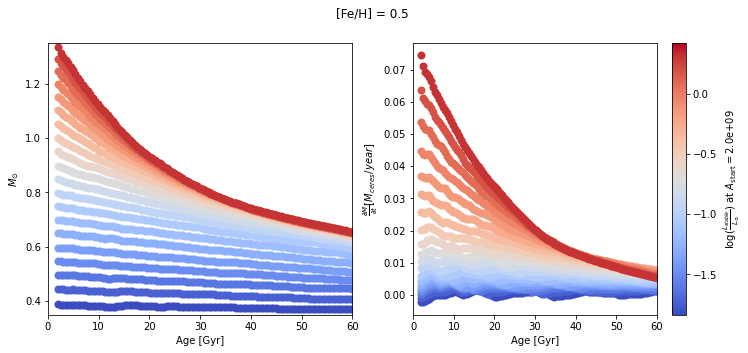

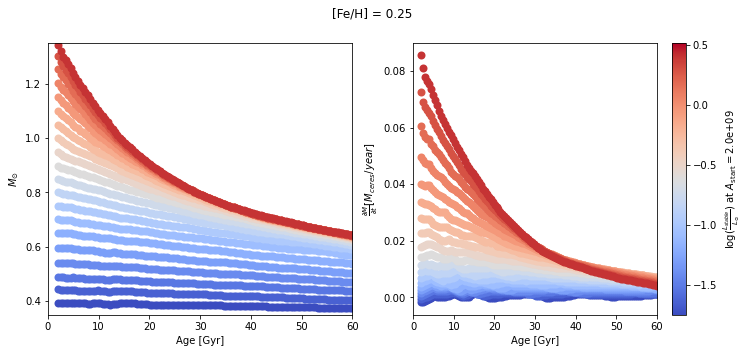

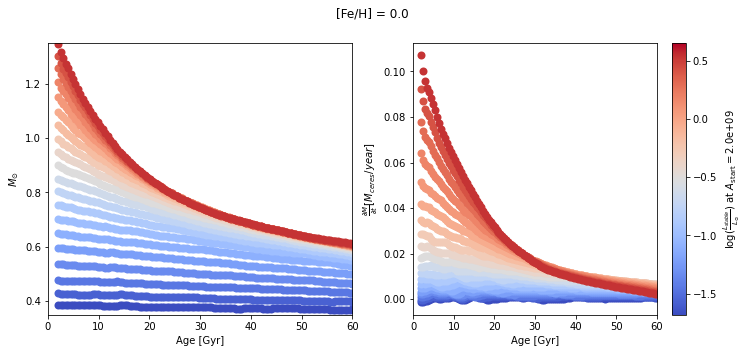

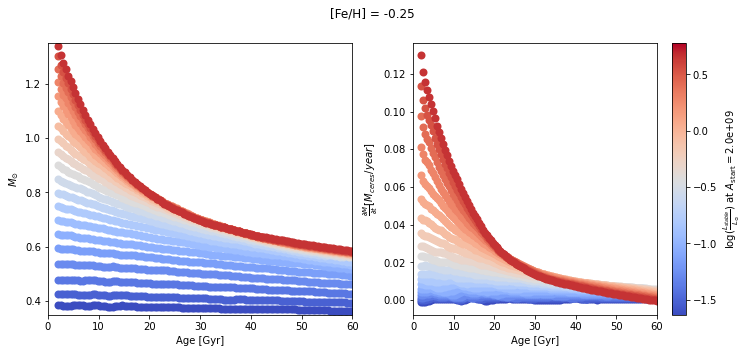

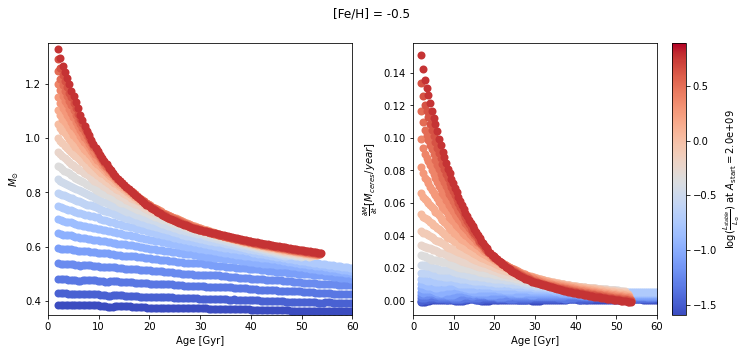

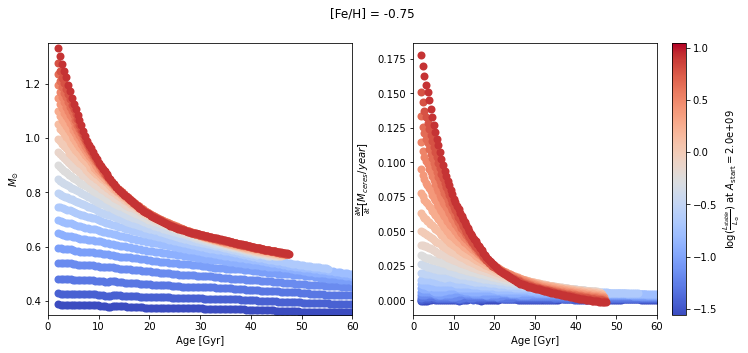

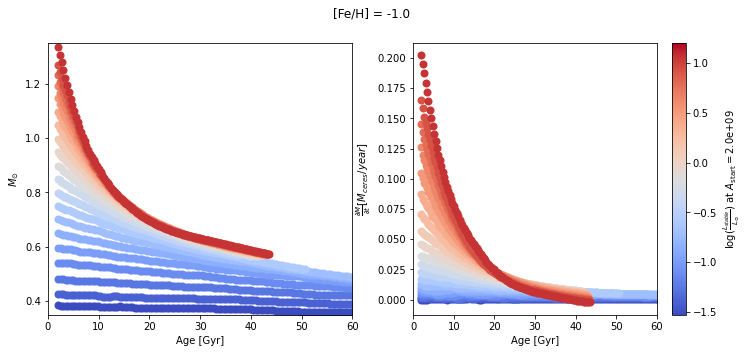

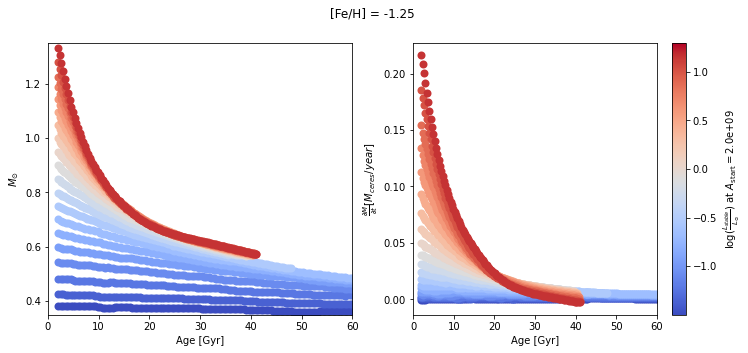

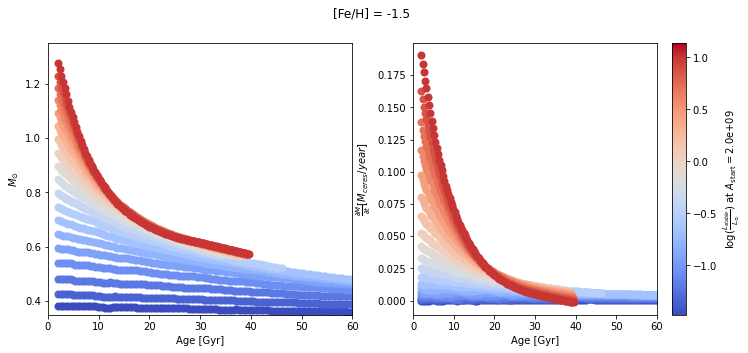

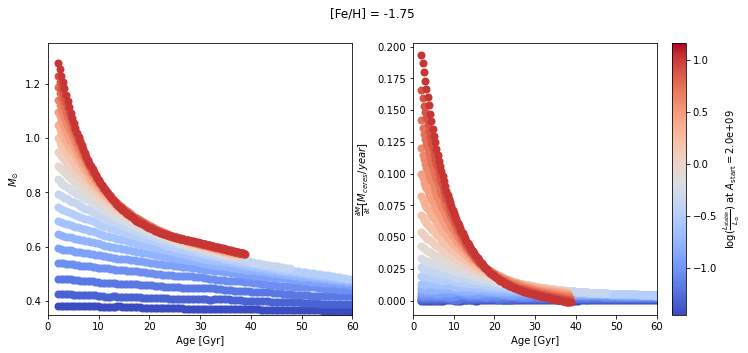

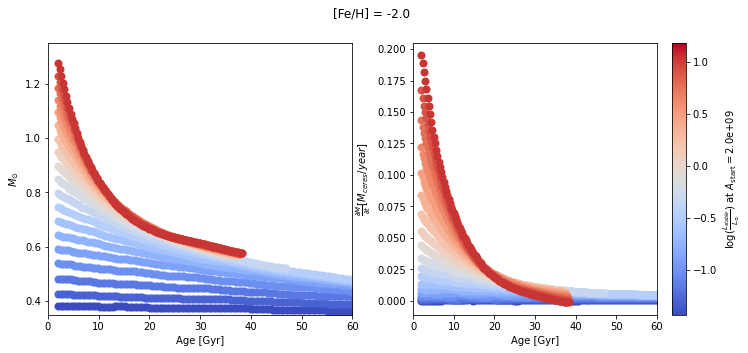

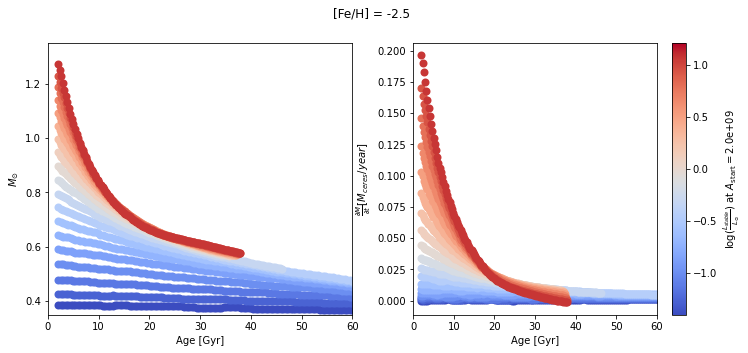

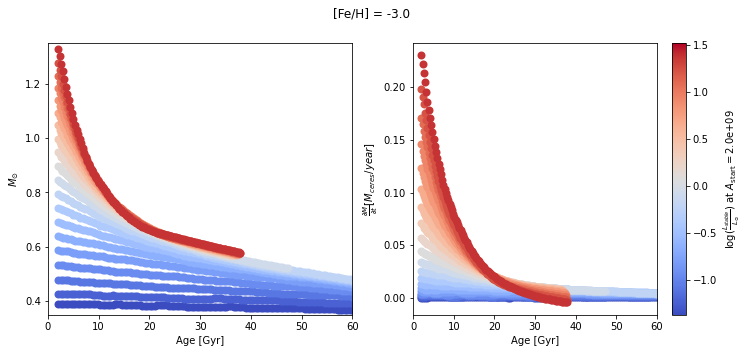

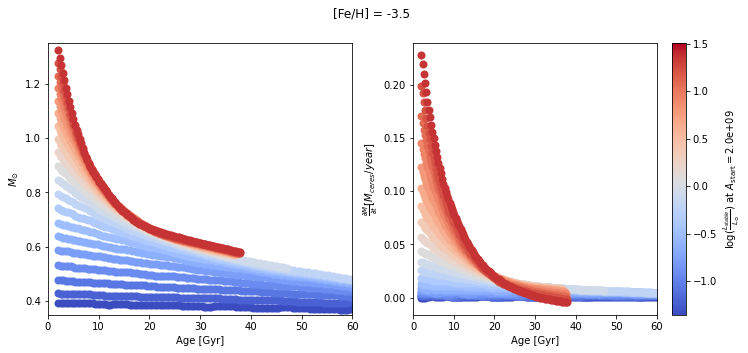

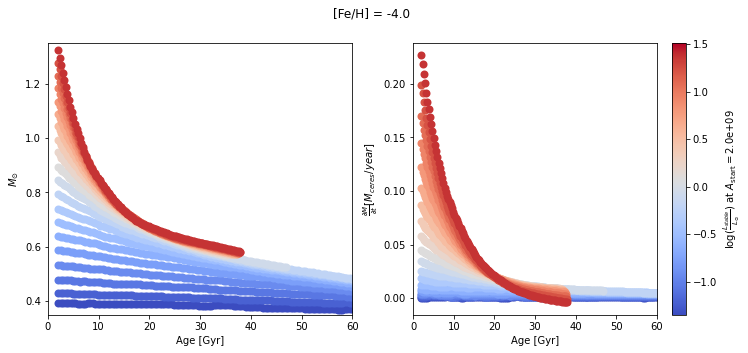

In [218]:
for i in range(len(all_indices)) :
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    
    for num,x in enumerate(all_indices[i]):
        pts = np.linspace(a_start, min(60e9,max(all_a[i][num])*1.2),120)
        
        m_predict,dmdt_predict,age_in,lum_in,feh_in = calc_ML([feh[i]],pts,[all_l_stables[i][x]])

        
        a,b,c = all_exp_fits[i][num]
        axs[0].scatter(pts/1e9, m_predict, color=CMAP(x/len(all_l_stables[i])), lw=2)
        axs[1].scatter(pts/1e9, dmdt_predict, color=CMAP(x/len(all_l_stables[i])), lw=2)
        #axs[1].plot(pts/1e9, -exp_der(pts,a,b,c)*m_sol/m_ceres, color=CMAP(x/len(all_l_stables[i])), lw=4)
        
    c = axs[1].scatter(np.zeros(len(all_l_stables[i])), np.zeros(len(all_l_stables[i])), cmap=CMAP, c=all_l_stables[i], s=0)
    axs[0].set_xlim(0,60)
    axs[0].set_ylim(m_eval[0]-0.05, m_eval[-1])
    axs[0].set_xlabel("Age [Gyr]")
    axs[0].set_ylabel(r"$M_{\odot}$")

    axs[1].set_xlim(0,60)
    axs[1].set_xlabel("Age [Gyr]")
    axs[1].set_ylabel(r"$\frac{\partial M}{\partial t} [M_{ceres}/year]$")
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, label=r"log($\frac{L_{stable}}{L_{\odot}}$) at $A_{\rm start}=$"+str(f"{a_start:.1e}"))    
    plt.suptitle("[Fe/H] = "+str(feh[i]))
    if(feh[i] < 0): feh_st = "m"+str(np.abs(feh[i]))
    else: feh_st = "p"+str(np.abs(feh[i]))
    plt.savefig("figures/ml_figs/feh_"+feh_st+".pdf")
    

# Checking m vs a against another set of evolutionary tracks


In [102]:
def get_geneva_data(file):
    f = open(file)
    age_full, mass_full, log_L_full, log_T_full = [],[],[],[]
    a=[]
    for i,line in enumerate(f):
        if(i==0): continue
        if("Isochrone" in line): 
            age = float(line.split()[-1])
            new_track = True
            continue
        if(new_track):
            if(len(a) > 0):
                age_full.append(a)
                mass_full.append(m)
                log_L_full.append(l)
                log_T_full.append(t)
            a,m,l,t = [],[],[],[]
        
        s=line.split()
        if(s==[]): continue
        mass, log_T, log_L = float(s[0]), float(s[3]), float(s[4])
        a.append(age), m.append(mass), l.append(log_L), t.append(log_T)            
        new_track = False
        
    return age_full,mass_full,log_L_full, log_T_full

file1, file2 = "geneva_data/low_mass.dat", "geneva_data/medium_mass.dat"        
log_age_full,mass_full,log_L_full, log_T_full = get_geneva_data(file1)
age_full = [[10**a for a in list_] for list_ in log_age_full]

age_filt = np.where(np.array([xi[0] for xi in log_age_full]) >7.7)
age_full1, mass_full1, log_L_full1 = np.array(age_full)[age_filt].tolist(), np.array(mass_full)[age_filt].tolist(), np.array(log_L_full)[age_filt].tolist()


log_age_full,mass_full,log_L_full, log_T_full = get_geneva_data(file2)
age_full = [[10**a for a in list_] for list_ in log_age_full]

age_filt = np.where(np.array([xi[0] for xi in log_age_full]) >7.7)
age_full2, mass_full2, log_L_full2 = np.array(age_full)[age_filt].tolist(), np.array(mass_full)[age_filt].tolist(), np.array(log_L_full)[age_filt].tolist()

<ipython-input-102-847deb429fab>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  age_full1, mass_full1, log_L_full1 = np.array(age_full)[age_filt].tolist(), np.array(mass_full)[age_filt].tolist(), np.array(log_L_full)[age_filt].tolist()
<ipython-input-102-847deb429fab>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  age_full2, mass_full2, log_L_full2 = np.array(age_full)[age_filt].tolist(), np.array(mass_full)[age_filt].tolist(), np.array(log_L_full)[age_filt].tolist()


In [98]:
a_sol = 4.603e9
m_sol = 1.98847e30
m_ceres = 9.1e20
time = np.linspace(4e9,6e10,30)
CMAP = plt.cm.coolwarm
mass_range = np.arange(0.6,1.2,0.05)
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels

In [103]:
mass_gen1 =[]
age_gen1 = []
for log_l, mass, a in  zip(log_L_full1, mass_full1, age_full1):
    lmsq = np.power(10,np.array(log_l))*np.power(mass,2)
    if(is_in(1, lmsq)):
        mass_gen1.append(interp1d(lmsq1,mass, kind="linear")(1))
        age_gen1.append(a[0])

In [104]:
mass_gen2 =[]
age_gen2 = []
for log_l, mass, a in  zip(log_L_full2, mass_full2, age_full2):
    lmsq = np.power(10,np.array(log_l))*np.power(mass,2)
    if(is_in(1, lmsq)):
        mass_gen2.append(interp1d(lmsq,mass, kind="linear")(1))
        age_gen2.append(a[0])

In [118]:
mass_mist =[]
age_mist = []
for log_l, mass, age in  zip(all_L[1], all_mass[1], all_ages[1]):
    lmsq = np.power(10,np.array(log_l))*np.power(mass,2)
    if(is_in(1, lmsq)):
        mass_mist.append(interp1d(lmsq,mass, kind="linear")(1))
        age_mist.append(interp1d(lmsq,age, kind="linear")(1))

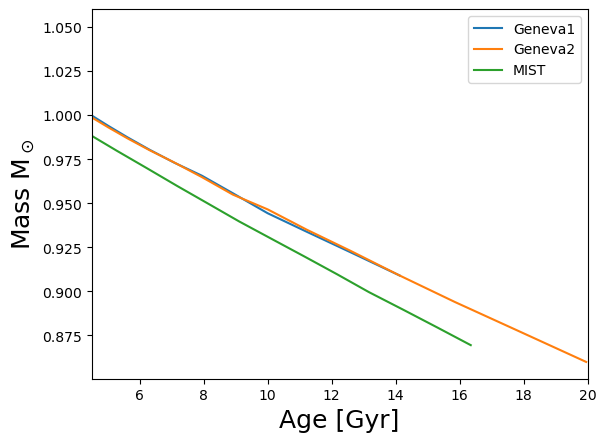

In [121]:
plt.plot(np.array(age_gen1)/1e9,mass_gen1,label="Geneva1")
plt.plot(np.array(age_gen2)/1e9,mass_gen2,label="Geneva2")
plt.plot(np.array(age_mist)/1e9,mass_mist,label="MIST")
plt.xlim(4.5,20)
plt.legend()
plt.xlabel("Age [Gyr]")
plt.ylabel(r"Mass ${\rm M}_\odot$")
plt.savefig("figures/gen_vs_mist.pdf")




### Checking the phases vs luminosity, deciding to stick with MS phase (phase == 0)

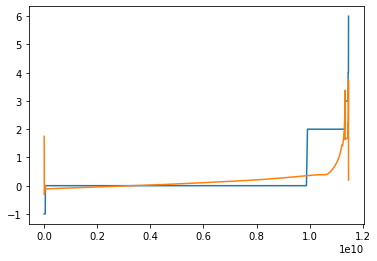

In [126]:
df = pd.read_csv("MIST_data/0010000M.track.eep", skiprows=11, delim_whitespace=True)
df
plt.plot(df["star_age"], df["phase"])
plt.plot(df["star_age"], df["log_L"])

# F-star investigation

In [204]:
i=np.where(np.abs(np.array(feh)+4) < 0.01)[0][0]
j=np.argmax(np.array(all_l_stables[i]))

pts = np.linspace(a_start,60e9,500)
m_predict,dmdt_predict,age_in,lum_in,feh_in = calc_ML([feh[i]],pts,[2.5-1])
fit_ages, fit_masses = all_a[i][j]/1e9, all_m[i][j]

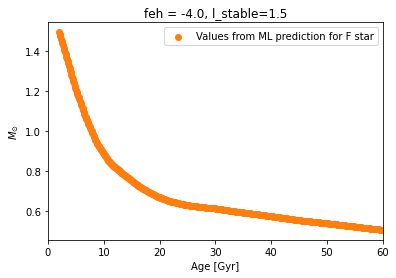

In [206]:
b=ml_bounds()
normalize = matplotlib.colors.Normalize(vmin=b.l_min, vmax=b.l_max)
plt.scatter(np.array(pts)/1e9, m_predict, c="tab:orange", label="Values from ML prediction for F star")
plt.xlabel("Age [Gyr]")
plt.ylabel(r"$M_{\odot}$")
plt.legend()
plt.xlim(0,60)
plt.title("feh = "+str(feh[i])+", l_stable="+str(2.5-1))
plt.savefig("figures/m_vs_a_for_f_star.pdf")

# Checking that a*M = constant for radius a and mass M (I'm worried I've forgotten something in the angular momentum consideration). Results show that $M\propto$ $\frac{1}{a}$

In [3]:
def calc_a(ps,n,m): 
    a=np.array([0.0,0.0])
    l = list(range(N))
    l.remove(n)
    for i in l:
        p1,p2=ps[n],ps[i]
        dist = get_dist(p1, p2)
        a+= G*m[i]*(p2 - p1)/np.power(dist,3)
    return a

def get_dist(p1,p2):
    return np.sqrt(np.sum(np.power(p1-p2,2),axis=0)) 

def calc_kinetic(vs,m,N):
    k=0
    for x in range(N): k+= 0.5*m[x]*np.sum(np.power(vs[x],2))
    return k

def calc_potential(ps,m,N):
    u=0
    for x in range(N):
        for y in range(N):
            if(x!=y): u-=G*m[x]*m[y]/(get_dist(ps[x],ps[y]))
    return u
    
def evolve_leap_frog(ps,vs,m1,m2,N,dt, t_max):
    p = np.array(ps)
    k = [calc_kinetic(vs,m1,N)]
    u = [calc_potential(ps,m1,N)]
    for n in range(N): vs[n] += (dt/2)*calc_a(ps,n,m1)
    t_s = 4*t_year
    t_e = 30*t_year
    for t in np.arange(0,t_max,dt):
        if(t<t_s): m=m1
        elif(t<t_e): m =list(np.array(m1)*(t_e-t)/(t_e-t_s) + np.array(m2)*(t-t_s)/(t_e-t_s))
        else: m=m2
        for n in range(N): ps[n] += dt*vs[n]
        for n in range(N): vs[n] += dt*calc_a(ps,n,m)
        p = np.concatenate((p,np.array(ps)),axis=1)
        k.append(calc_kinetic(vs,m,N))
        u.append(calc_potential(ps,m,N))
    return p, np.arange(0,t_max+dt/2,dt),k,u
  
    
    
    
AU = 1.496e+11 #meters
box_size = 20*AU #
N=2
dim = 2
m1 = [2e30, 6e24]
m2 = [0.8e30, 6e24]
G=6.26e-11
dt=2e4 #seconds
t_year=3.154e+7 #seconds per year
t_max=40*t_year
ps = [(0.0,0.0), (AU,0.0)]
vs = [(0.0,0.0),(0.0,np.sqrt(G*2e30/AU))]

for x in range(len(ps)): ps[x]=np.array(ps[x])
for x in range(len(vs)): vs[x]=np.array(vs[x])
p,t,k,u = evolve_leap_frog(ps,vs,m1,m2,N,dt,t_max)

1261600000.0


Text(0, 0.5, 'y(m)')

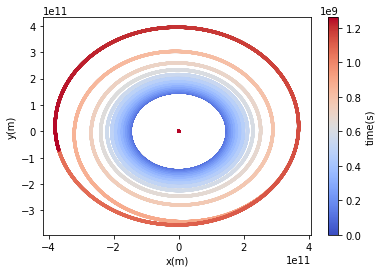

In [4]:
p1x = p[0][0::2]
p1y = p[0][1::2]
p2x = p[1][0::2]
p2y = p[1][1::2]
plt.scatter(p2x,p2y,s=5,c=t, cmap=cm.coolwarm)
plt.scatter(p1x,p1y,s=5,c=t, cmap=cm.coolwarm)
plt.colorbar(label="time(s)")
plt.xlabel("x(m)")
plt.ylabel("y(m)")

In [76]:
r_final = np.sqrt(p2x[-1]*p2x[-1] + p2y[-1]*p2y[-1])
r_init = AU
m_final, m_init = 0.8e30,2e30
print(m_final*r_final)
print(m_init*r_init)

3.0071027169797337e+41
2.992e+41


roughly the same, so M*a constant holds

# Graveyard (things I'll probably never use again, but keeping just in case)

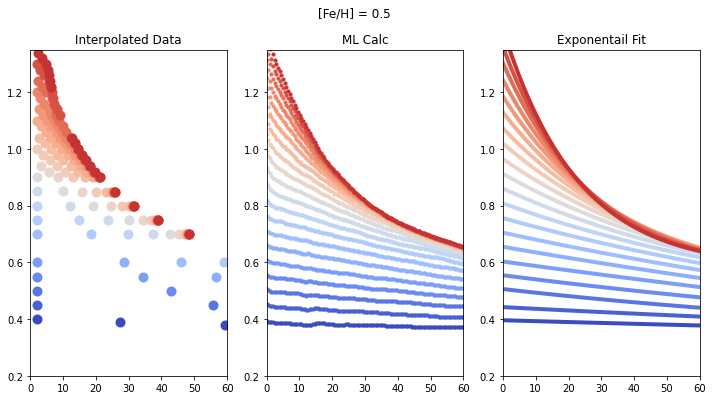

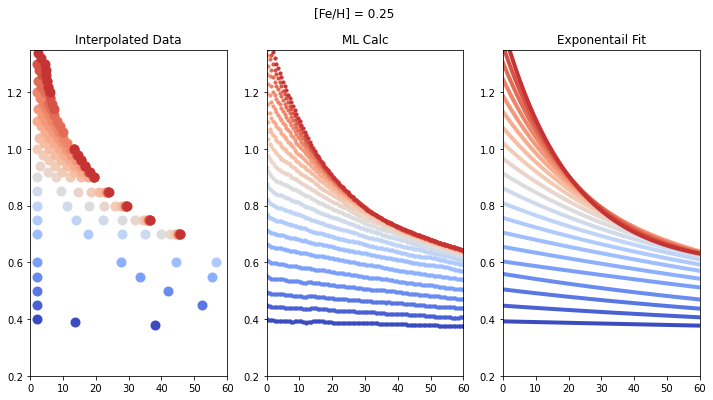

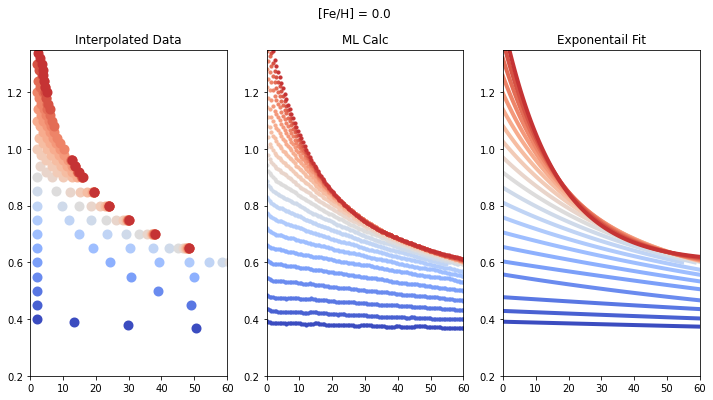

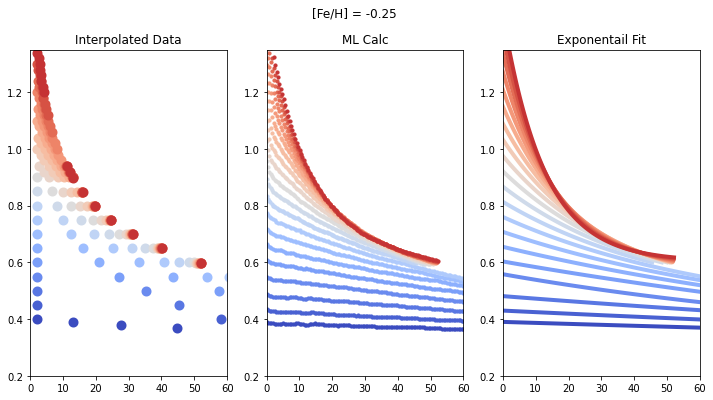

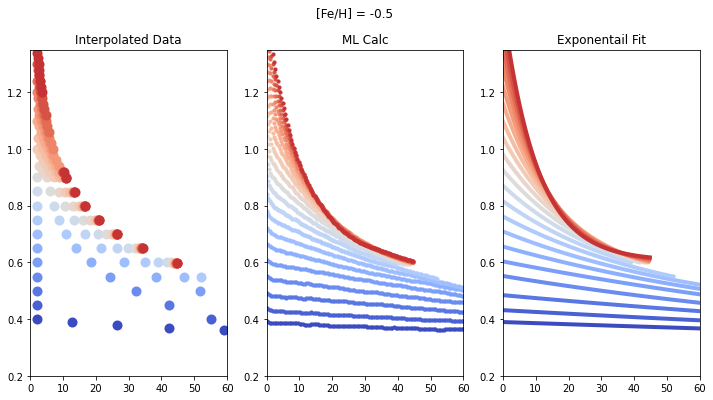

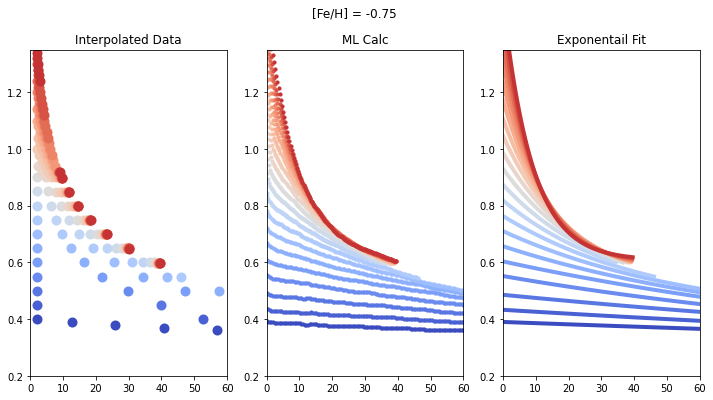

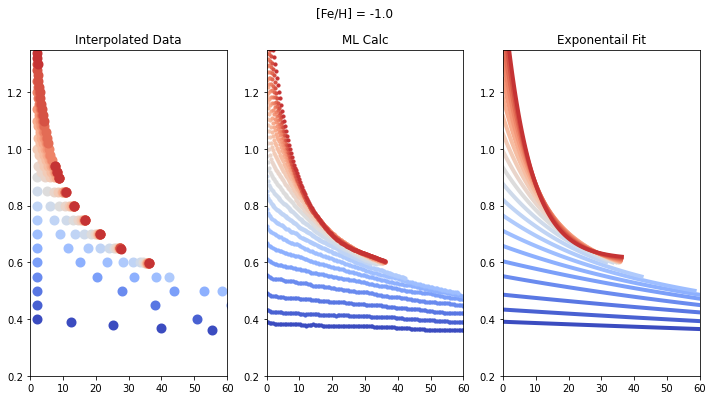

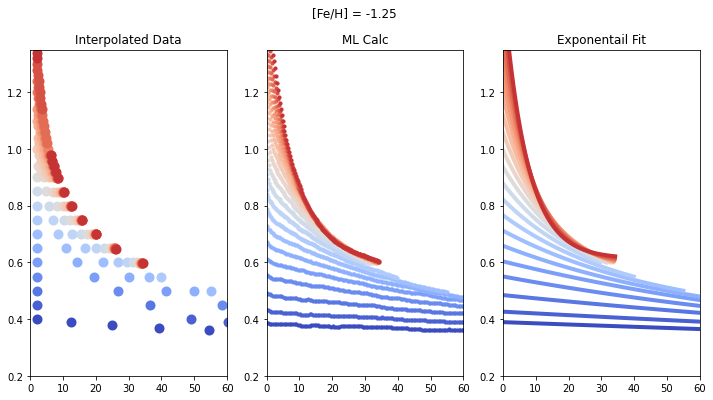

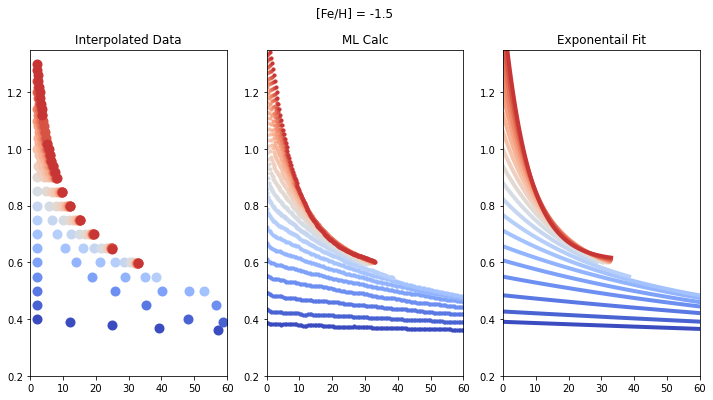

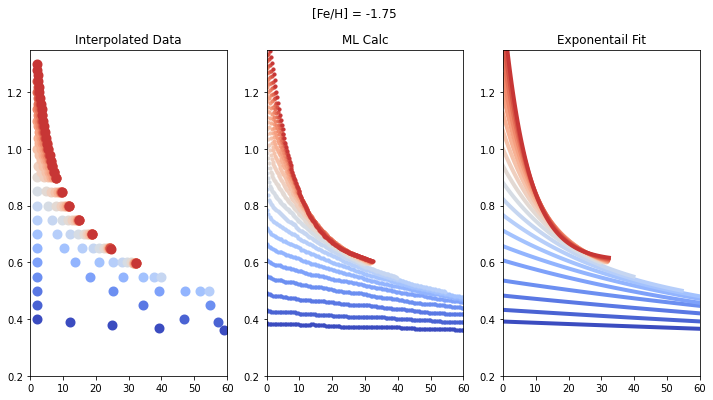

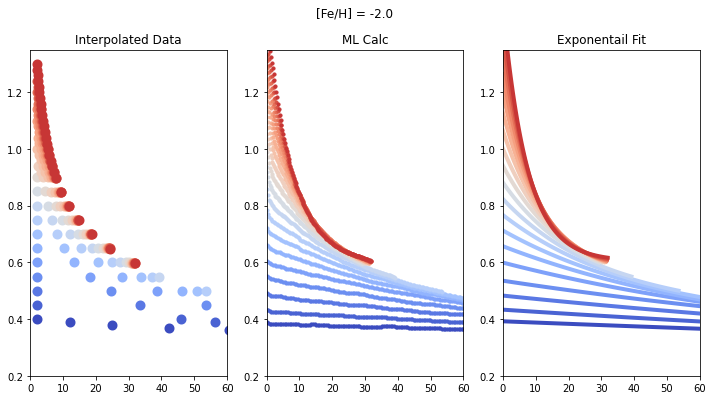

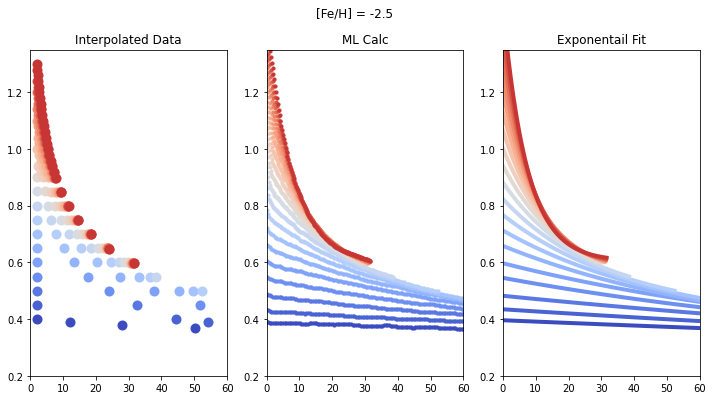

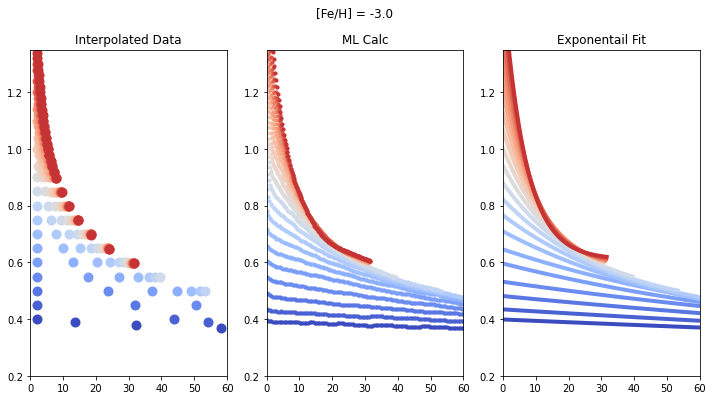

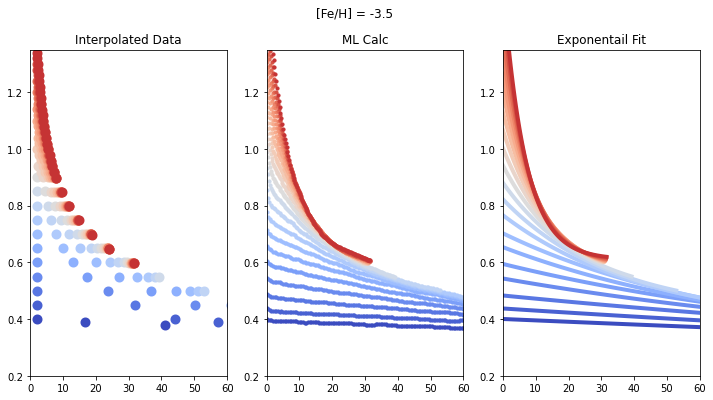

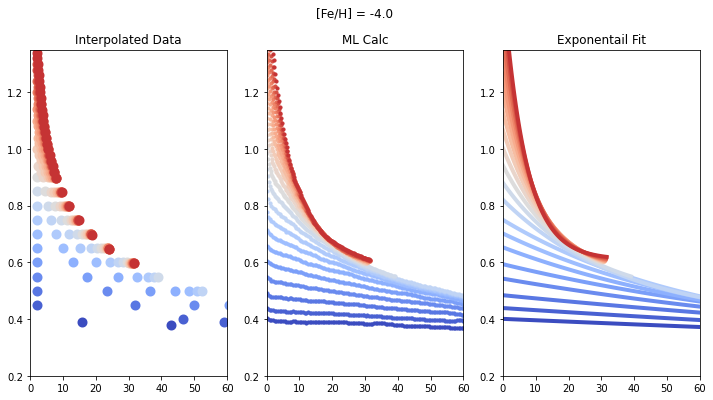

In [161]:
for i in range(len(all_indices)):
    fig, axs = plt.subplots(1,3, figsize=(12,6))
    for num,x in enumerate(all_indices[i]):

        pts = np.linspace(0, min(60e9,max(all_a[i][num])),120)
        axs[0].scatter(all_a[i][num]/1e9, all_m[i][num], color=CMAP(x/len(all_l_stables[i])), lw=4)


        m_predict,age_in,lum_in,feh_in = calc_ML([feh[i]],pts,[all_l_stables[i][x]])


        axs[1].scatter(age_in/1e9, m_predict, color=CMAP(x/len(all_l_stables[i])), s=10)
        a,b,c = all_exp_fits[i][num]
        #axs[2].scatter(age_in/1e9, m_predict, color=CMAP(x/len(all_l_stables[i])), s=15, alpha=0.5)

        axs[2].plot(pts/1e9, exp(pts,a,b,c), color=CMAP(x/len(all_l_stables[i])), lw=4)
    titles = ["Interpolated Data", "ML Calc", "Exponentail Fit"]
    for x in range(3): 
        axs[x].set_xlim(0,60)
        axs[x].set_ylim(m_eval[0]-0.2, m_eval[-1])
        axs[x].set_title(titles[x])

    plt.suptitle("[Fe/H] = "+str(feh[i]))

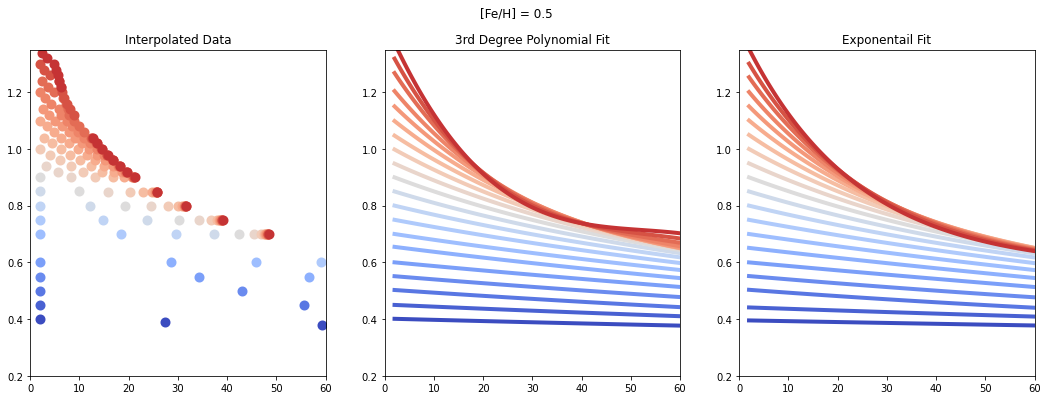

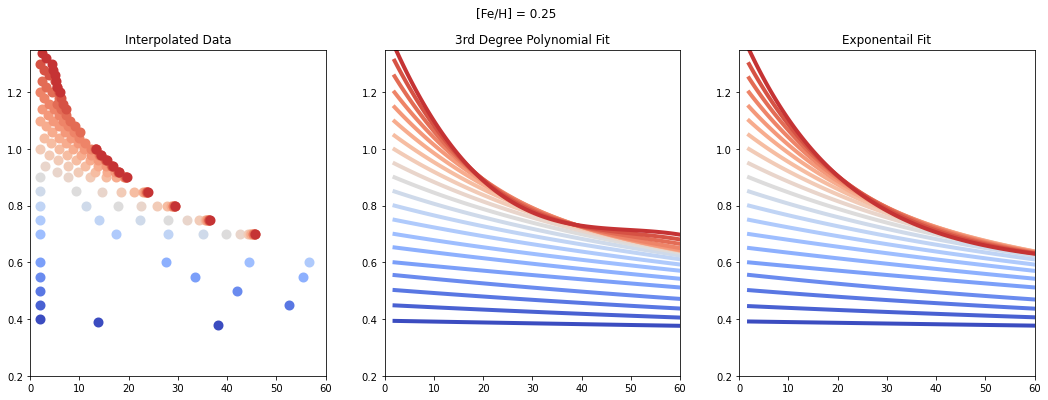

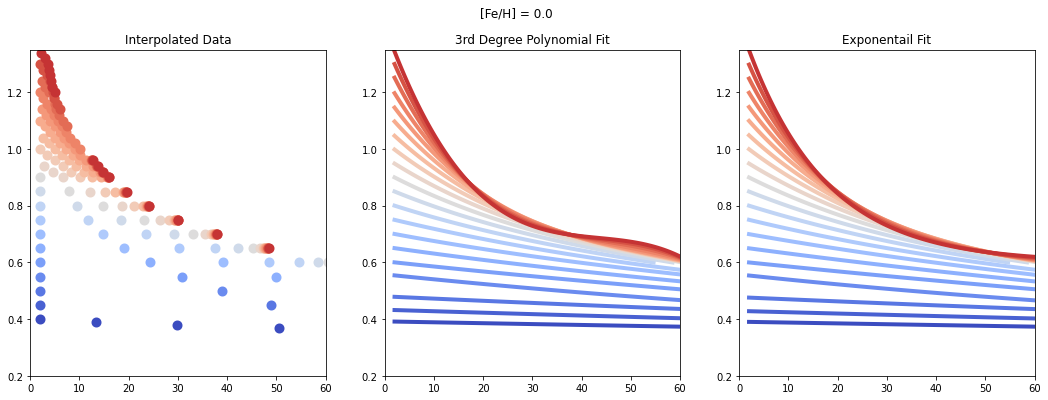

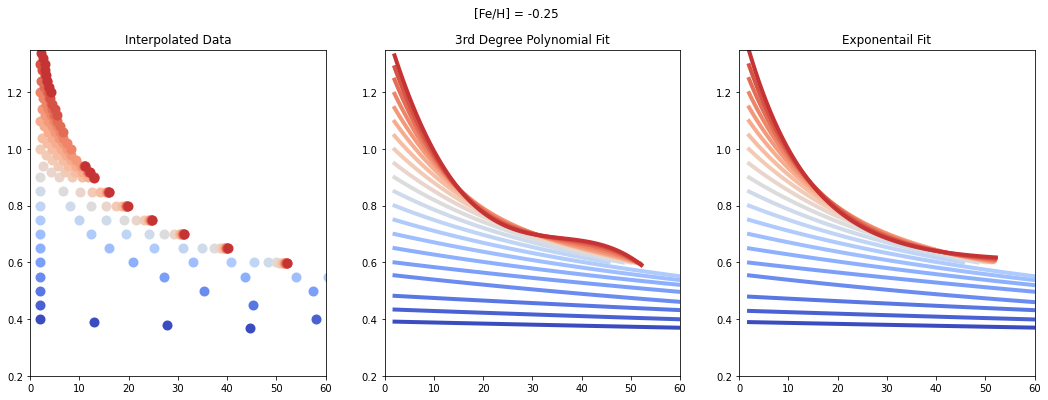

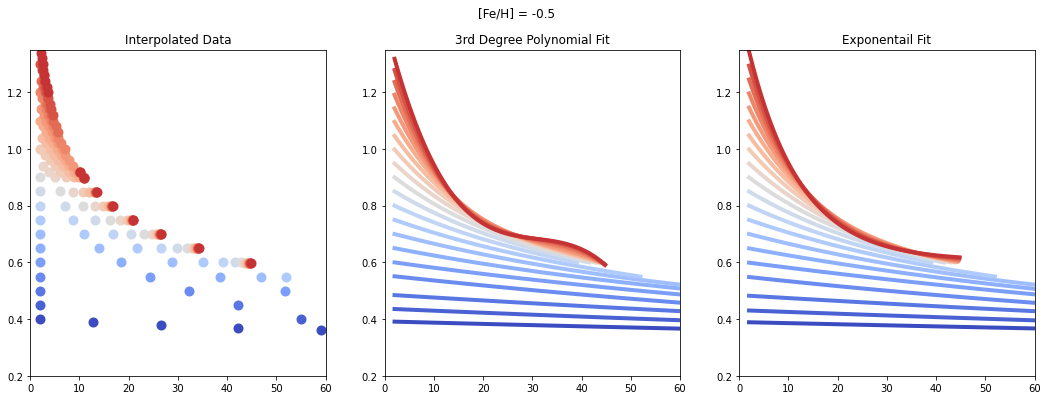

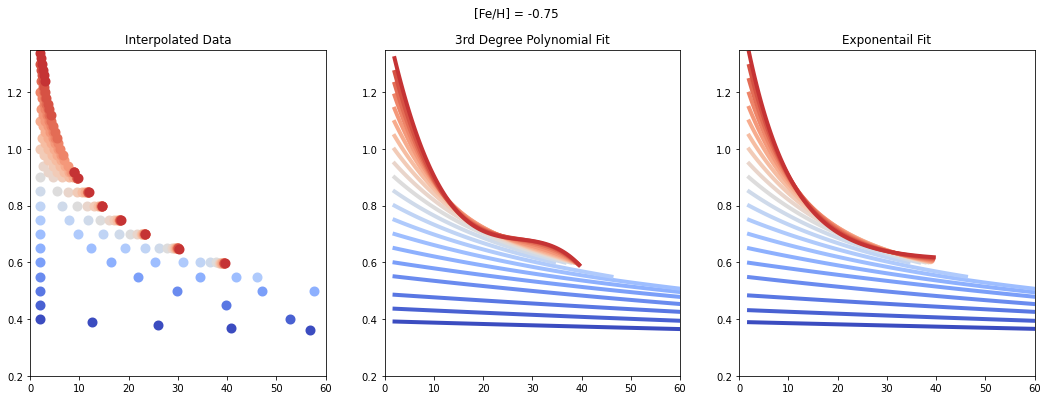

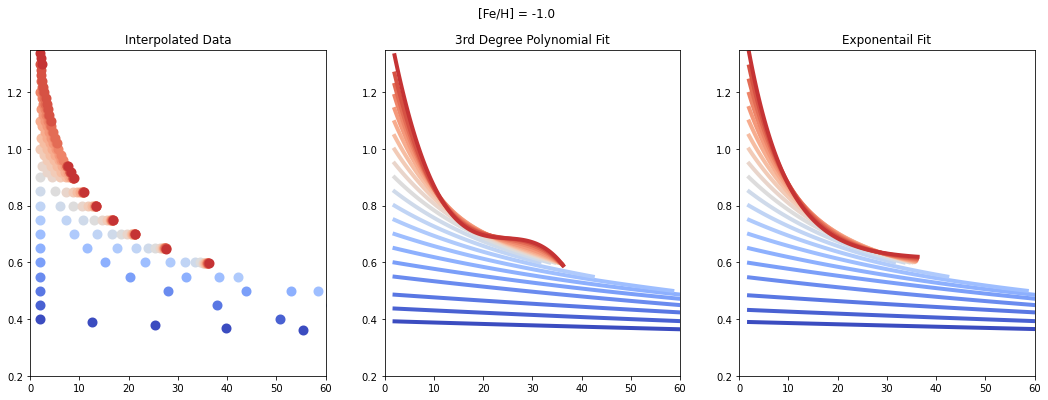

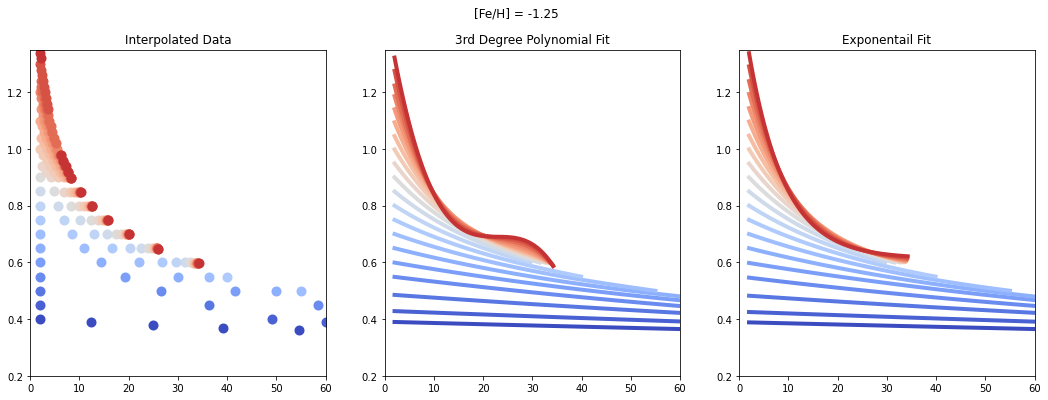

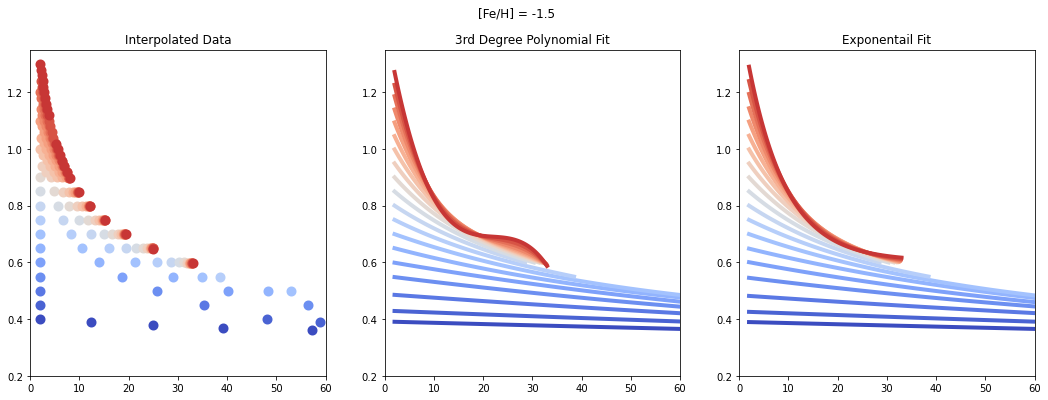

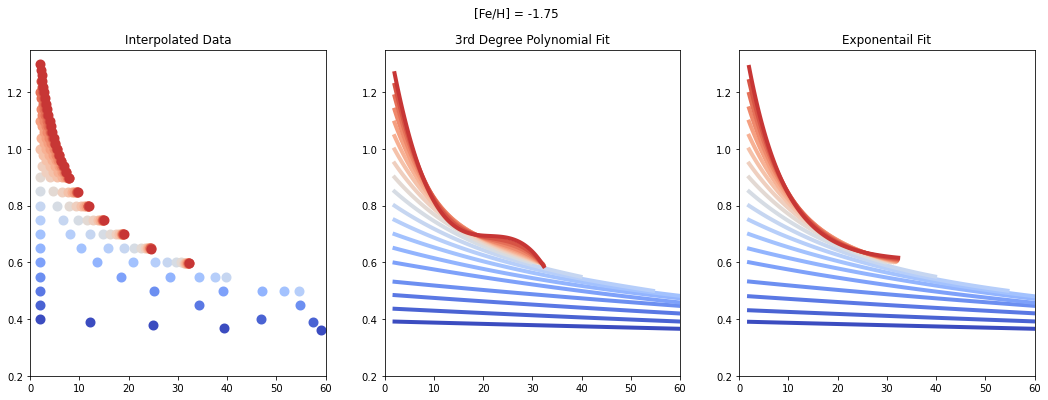

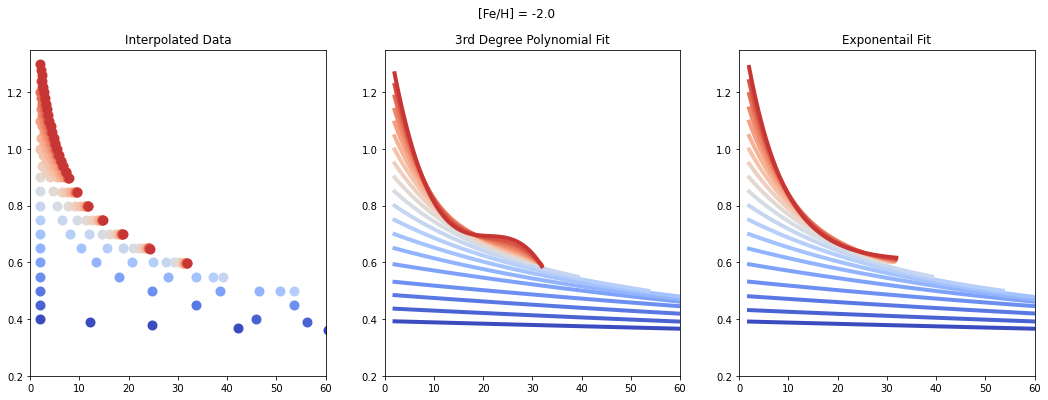

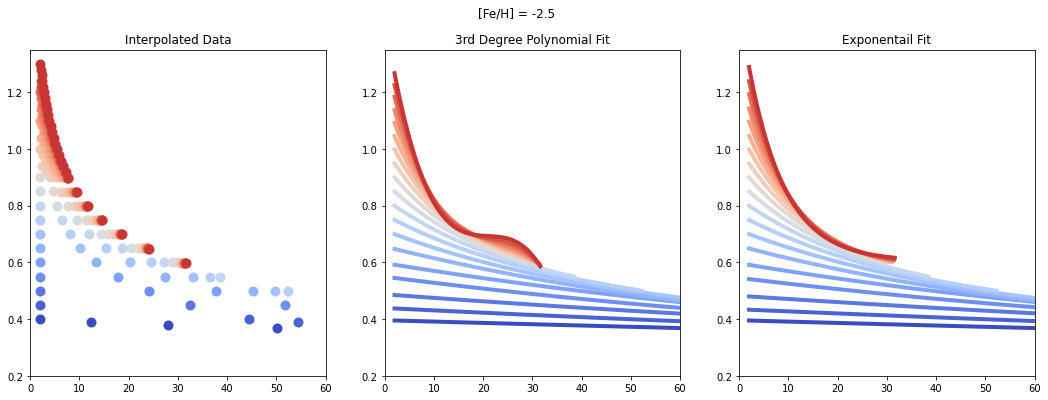

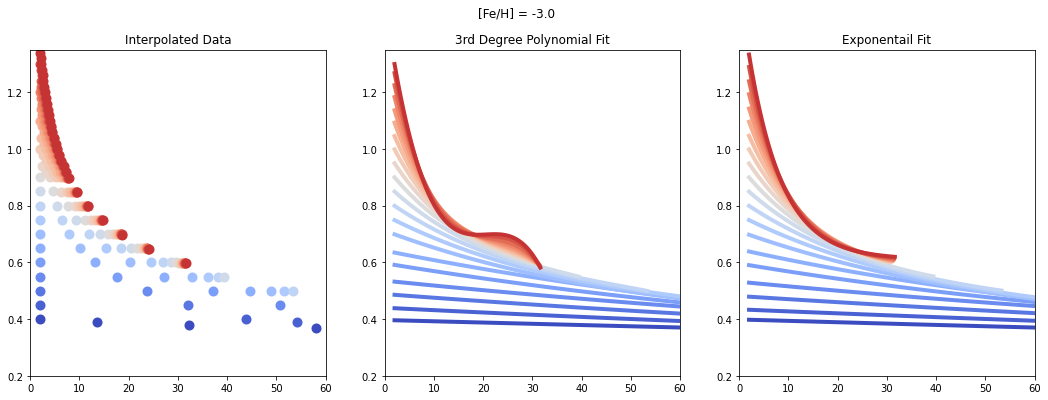

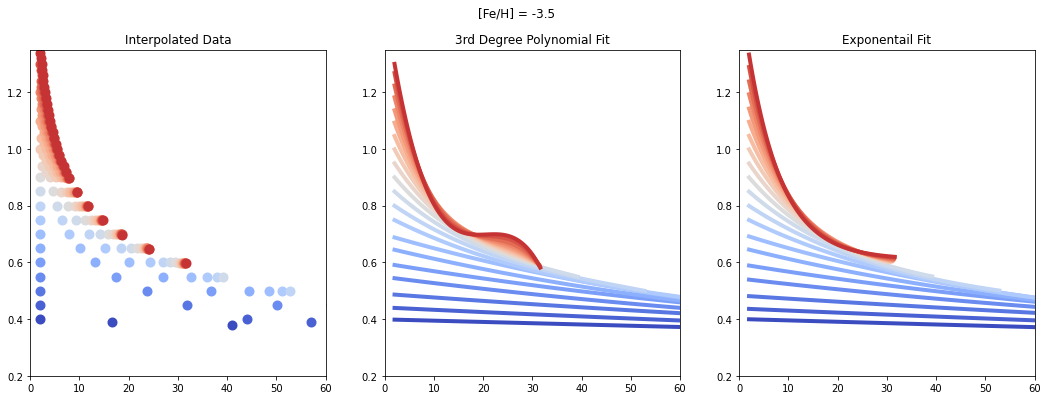

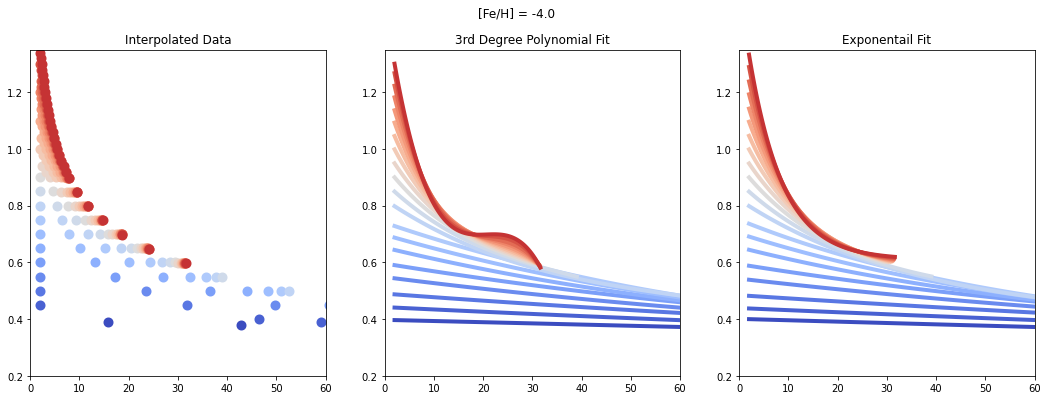

In [12]:
for i in range(len(all_indices)) :
    #if(np.abs(feh[i]+2.5 ) < 0.05):
    fig, axs = plt.subplots(1,3, figsize=(18,6))
    for num,x in enumerate(all_indices[i]):
        pts = np.linspace(a_start, min(60e9,max(all_a[i][num])),120)
        axs[0].scatter(all_a[i][num]/1e9, all_m[i][num], color=CMAP(x/len(all_l_stables[i])), lw=4)
        axs[1].plot(pts/1e9, (np.poly1d(all_poly_fits[i][num]))(pts), color=CMAP(x/len(all_l_stables[i])), lw=4)
        a,b,c = all_exp_fits[i][num]
        axs[2].plot(pts/1e9, exp(pts,a,b,c), color=CMAP(x/len(all_l_stables[i])), lw=4)
    titles = ["Interpolated Data", "3rd Degree Polynomial Fit", "Exponentail Fit"]
    for x in range(3): 
        axs[x].set_xlim(0,60)
        axs[x].set_ylim(m_eval[0]-0.2, m_eval[-1])
        axs[x].set_title(titles[x])

    plt.suptitle("[Fe/H] = "+str(feh[i]))

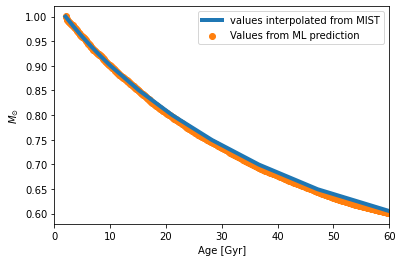

In [96]:
i=np.where(np.abs(np.array(feh)) < 0.01)[0][0]
j=np.argmin(np.abs(np.array(all_l_stables[i])))

pts = np.linspace(a_start,60e9,500)
m_predict,age_in,lum_in,feh_in = calc_ML([0.0],pts,[all_l_stables[i][j]])
solar_ages, solar_masses = all_a[i][j]/1e9, all_m[i][j]

b=ml_bounds()
normalize = matplotlib.colors.Normalize(vmin=b.l_min, vmax=b.l_max)
#plt.scatter(np.array(age)/1e9, m_predict, c=lum, s=5, cmap=CMAP, norm=normalize, label="Values from ML prediction")
plt.scatter(np.array(pts)/1e9, m_predict, c="tab:orange", label="Values from ML prediction")
plt.plot(solar_ages,solar_masses, c="tab:blue", label="values interpolated from MIST", lw=4)
plt.xlabel("Age [Gyr]")
plt.ylabel(r"$M_{\odot}$")
plt.legend()
plt.xlim(0,60)
plt.savefig("figures/ml_vs_mist_for_sun.pdf")